In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla_simulator as jla
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
import compression.IMNN.IMNN_delfi as IMNN
%matplotlib inline

In [3]:
### SET UP FOR SIMULATION CODE ###

JLASimulator = jla.JLA_Model()

/hdd/delfi/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [4]:
# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    
    return JLASimulator.simulation(theta, seed)
simulator_args = None

In [5]:
### SET UP THE PRIOR ###

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior_covariance = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
prior_covariance[0,1] = prior_covariance[1,0] = -0.8*0.4*0.75
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

number of partial simulations =  500
[740, 370, 185, 92, 46, 23, 11]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta


100%|██████████| 100/100 [00:30<00:00,  4.13it/s, detF=2.82e+10, detF_test=1.06e+10]


saving the graph as compression/cosmic_shear.meta


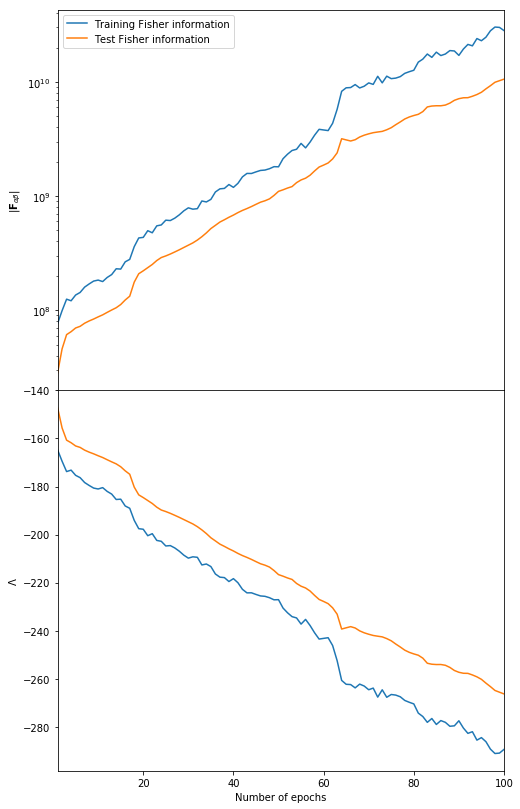

In [6]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])
h = abs(0.01*theta_fiducial)

# Number of parameters to train IMNN
initial_sims = 5000
partial_fraction = 0.1

# Filename for saving IMNN
filename = 'jla'

# Get shape of the simulation
shape = list(simulator(theta_fiducial, 0, simulator_args).shape)

# Build training simulations for IMNN (and save them) and initialise IMNN
compression_network = IMNN.get_network(simulator, simulator_args, shape, theta_fiducial, h, initial_sims, partial_fraction, filename, 1e-6, make_simulations = False, load_network = False)

# Train IMNN
# Number of training epochs
num_epochs = 100

IMNN.train_IMNN(compression_network, num_epochs)
IMNN.plot_train_history(compression_network)

# IMNN score
compressor = IMNN.IMNN_MLE
compressor_args = compression_network

IMNN_summary = IMNN.IMNN_compressor

# Pull out Fisher matrix inverse
Finv = np.linalg.inv(compression_network.sess.run(compression_network.test_F))

100%|██████████| 1000/1000 [04:06<00:00,  4.21it/s, detF=3.97e+22, detF_test=6.55e+15]


saving the graph as compression/cosmic_shear.meta


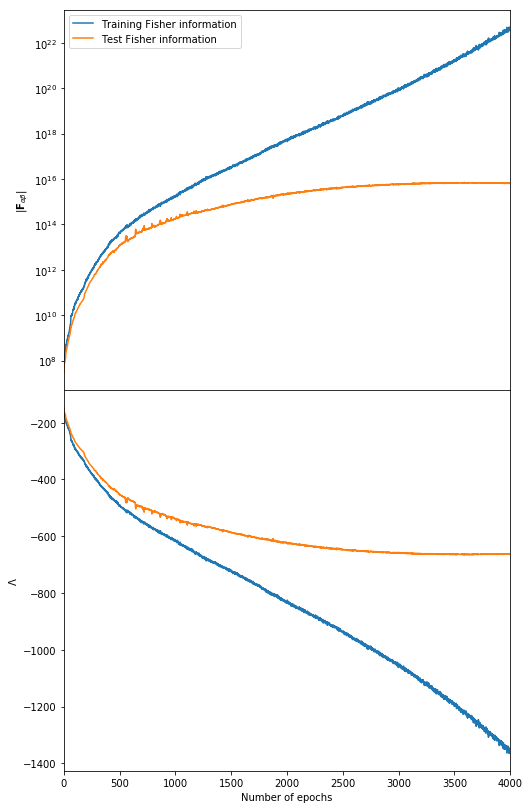

In [10]:
IMNN.train_IMNN(compression_network, 1000, to_continue = True)
IMNN.plot_train_history(compression_network)
Finv = np.linalg.inv(compression_network.sess.run(compression_network.test_F))

In [11]:
simulation = simulator(theta_fiducial, 42, simulator_args)
data = compressor(simulation, compressor_args)
summary_data = IMNN_summary(simulation, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN maximum likelihood estimate = ", data)
print("IMNN summaries = ", summary_data)
print("|F|", np.linalg.det(compression_network.sess.run(compression_network.test_F)))
print("IMNN Fisher forecast =  ", np.sqrt(np.diag(Finv)))

Fiducial parameter values =  [  0.20181324  -0.74762939 -19.04253368   0.12566322   2.64387045
  -0.05252869]
IMNN maximum likelihood estimate =  [ 1.5764765e-01 -8.1089497e-01 -1.9013023e+01  1.1196892e-01
  2.4218528e+00  6.2495843e-04]
IMNN summaries =  [-7.6636977 36.14477   77.626274  62.54583   61.61282   -7.799138 ]
|F| 6551431400000000.0
IMNN Fisher forecast =   [0.04910631 0.06865596 0.02695586 0.02307583 0.20432408 0.04485328]


Text(0.5, 1.0, 'Inverse Fisher information\n from IMNN')

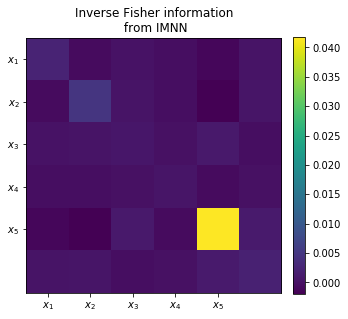

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
p = ax.imshow(Finv)
plt.colorbar(p, ax = ax, fraction = 0.046, pad = 0.04)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels([r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$"])
ax.set_title("Inverse Fisher information\n from IMNN")

In [15]:
compressor = IMNN.IMNN_compressor

In [16]:
### LOAD IN THE DATA VECTOR ###
data = compressor(JLASimulator.data, compressor_args)

In [17]:
# Create the neural density estimator (MAF)
#MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=6, n_outputs=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh)

NDE = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, NDE, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/maf")

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args, proposal = prior)

Simulations:   0%|          | 0/499 [00:00<?, ?it/s]

Running initial 500 sims...
Simulator returns exception for parameter values: [  0.37470671  -1.20198238 -19.11115178   0.08983347   2.36919169
  -0.11758423] (rank 0)
Simulator returns exception for parameter values: [  0.58310077  -1.42776121 -18.98675923   0.14931386   2.75545249
  -0.12851124] (rank 0)
Simulator returns exception for parameter values: [ 9.14512967e-03 -4.25101081e-01 -1.90574433e+01  1.40516802e-01
  2.64442525e+00 -1.16767218e-01] (rank 0)
Simulator returns exception for parameter values: [  0.45207914  -0.70335513 -18.99402096   0.15201952   2.80848054
  -0.027041  ] (rank 0)
Simulator returns exception for parameter values: [  0.27193372  -1.45533299 -19.00703818   0.13019219   2.66789471
  -0.11383743] (rank 0)
Simulator returns exception for parameter values: [  0.38885351  -1.09871714 -18.92442439   0.10263482   2.55328209
  -0.07198655] (rank 0)
Simulator returns exception for parameter values: [  0.3329136   -0.31990422 -19.10172885   0.16023369   3.1747245

Simulator returns exception for parameter values: [  0.37240862  -1.44218731 -19.0100312    0.10871608   2.46784583
  -0.0206818 ] (rank 0)
Simulator returns exception for parameter values: [  0.24461761  -1.21786062 -19.07090233   0.10373699   2.45486914
  -0.02057108] (rank 0)
Simulator returns exception for parameter values: [  0.24639313  -0.66298001 -19.12848983   0.14120701   2.56976296
  -0.02902338] (rank 0)
Simulator returns exception for parameter values: [ 3.89873890e-01 -4.65144961e-01 -1.91918366e+01  8.09797797e-02
  2.21858592e+00  1.31292052e-02] (rank 0)
Simulator returns exception for parameter values: [  0.33536275  -0.1381556  -19.16416891   0.12015851   2.42079442
  -0.14332683] (rank 0)
Simulator returns exception for parameter values: [  0.26692773  -0.75517797 -18.89865503   0.14077029   2.34395329
   0.04270463] (rank 0)
Simulator returns exception for parameter values: [  0.42926709  -1.01032179 -19.09660365   0.08513242   2.72840003
  -0.07663504] (rank 0)
Si

Simulator returns exception for parameter values: [  0.59632974  -1.42544071 -19.07285999   0.10014127   1.95941659
  -0.05955139] (rank 0)
Simulator returns exception for parameter values: [  0.56914449  -0.88740038 -19.08540407   0.11065996   2.62546407
   0.02745101] (rank 0)
Simulator returns exception for parameter values: [  0.14992145  -0.66785397 -18.92183562   0.13894228   2.32213551
  -0.03767476] (rank 0)
Simulator returns exception for parameter values: [  0.4992887   -0.53586598 -18.89194593   0.09962265   2.39728562
  -0.11287889] (rank 0)
Simulator returns exception for parameter values: [  0.20639206  -0.39972682 -18.95126655   0.12310122   2.52003812
  -0.0424121 ] (rank 0)
Simulator returns exception for parameter values: [  0.22398439  -0.79682702 -19.06803917   0.15932121   2.04703452
   0.02667169] (rank 0)
Simulator returns exception for parameter values: [  0.04340524  -0.14556533 -18.86956519   0.12022741   2.77993949
  -0.11466365] (rank 0)
Simulator returns ex

Simulator returns exception for parameter values: [ 4.92826691e-01 -8.73310120e-01 -1.90106203e+01  7.68081855e-02
  2.53027915e+00 -7.74210144e-03] (rank 0)
Simulator returns exception for parameter values: [  0.28044113  -1.35299712 -19.05524045   0.16760264   2.91172293
  -0.0531002 ] (rank 0)
Simulator returns exception for parameter values: [  0.20264641  -0.7388968  -18.85958634   0.16564897   3.15469506
  -0.05795226] (rank 0)
Simulator returns exception for parameter values: [ 6.44532693e-02 -7.73447998e-01 -1.91107875e+01  1.11521932e-01
  2.46293280e+00 -8.33330441e-03] (rank 0)
Simulator returns exception for parameter values: [ 4.63442923e-01 -1.13367820e+00 -1.91338586e+01  1.02832977e-01
  2.73370433e+00  1.14490251e-02] (rank 0)
Simulator returns exception for parameter values: [  0.0450769   -0.16134134 -19.2587027    0.11038456   2.59223527
  -0.09548417] (rank 0)
Simulator returns exception for parameter values: [  0.05725393  -0.17992193 -19.32475048   0.11250675   2

Simulator returns exception for parameter values: [  0.06728719  -0.92917676 -19.06979377   0.17669766   2.14207944
  -0.1025655 ] (rank 0)
Simulator returns exception for parameter values: [  0.3931147   -1.23021584 -19.26899217   0.15486481   2.83959645
  -0.04741695] (rank 0)
Simulator returns exception for parameter values: [ 3.91629875e-01 -4.04001707e-01 -1.90275660e+01  1.47600439e-01
  2.52562945e+00  1.55991869e-02] (rank 0)
Simulator returns exception for parameter values: [  0.42831429  -0.85514806 -19.17700611   0.1321739    2.39201127
  -0.08191414] (rank 0)
Simulator returns exception for parameter values: [  0.3285015   -1.37483068 -19.11956949   0.10204683   2.909896
  -0.06981148] (rank 0)
Simulator returns exception for parameter values: [ 5.77142302e-01 -8.35126558e-01 -1.91485804e+01  1.17896123e-01
  2.89869072e+00 -5.26764062e-03] (rank 0)
Simulator returns exception for parameter values: [  0.20561201  -0.27353444 -19.00784539   0.13167046   2.51521943
  -0.03149

Simulator returns exception for parameter values: [  0.03326051  -0.26082827 -19.11074723   0.11489095   2.42843022
  -0.12163356] (rank 0)
Simulator returns exception for parameter values: [  0.35833459  -0.57411714 -18.99851164   0.14549813   2.68108505
  -0.07663627] (rank 0)
Simulator returns exception for parameter values: [ 4.94922095e-01 -5.60014703e-01 -1.91379283e+01  1.33714878e-01
  2.56870639e+00 -7.65589481e-03] (rank 0)
Simulator returns exception for parameter values: [  0.25391031  -0.85408976 -18.99590915   0.14690423   2.4329137
  -0.05305378] (rank 0)
Simulator returns exception for parameter values: [  0.52075439  -0.77502799 -19.24367527   0.10596612   2.38043419
  -0.04500565] (rank 0)
Simulator returns exception for parameter values: [  0.49229783  -0.36492706 -19.09949655   0.11256069   2.887418
  -0.03517115] (rank 0)
Simulator returns exception for parameter values: [  0.28642991  -1.44728505 -19.00793004   0.11055198   2.82028668
  -0.04993372] (rank 0)
Simul

Simulator returns exception for parameter values: [  0.26321729  -0.68761455 -18.97053996   0.14934056   2.4741076
  -0.0575307 ] (rank 0)
Simulator returns exception for parameter values: [  0.51987327  -0.26916637 -19.1801588    0.07867454   2.56877828
  -0.04921511] (rank 0)
Simulator returns exception for parameter values: [  0.38746372  -1.08203982 -19.07006393   0.13418776   2.86010772
  -0.14775244] (rank 0)
Simulator returns exception for parameter values: [  0.15242422  -0.43242238 -19.14179761   0.16827924   2.44114753
  -0.05206463] (rank 0)
Simulator returns exception for parameter values: [  0.52240884  -1.34969141 -19.2346573    0.11428364   2.85736014
  -0.06684476] (rank 0)
Simulator returns exception for parameter values: [  0.34286797  -1.29963268 -19.06752945   0.13498294   2.69009835
  -0.02478561] (rank 0)
Simulator returns exception for parameter values: [  0.41638589  -1.15273273 -19.10139006   0.09502622   3.04619376
  -0.04932748] (rank 0)
Simulator returns exc

Simulator returns exception for parameter values: [  0.37372363  -1.04959792 -19.24046747   0.1611103    2.29308001
  -0.0795639 ] (rank 0)
Simulator returns exception for parameter values: [  0.17960788  -0.85355847 -18.92565942   0.15570076   2.51629925
  -0.13969606] (rank 0)
Simulator returns exception for parameter values: [  0.07331796  -0.67989656 -19.1157135    0.10755703   2.43663428
  -0.06932708] (rank 0)
Simulator returns exception for parameter values: [  0.04578356  -0.27493021 -19.01396313   0.10223387   2.91776633
  -0.09900312] (rank 0)
Simulator returns exception for parameter values: [ 4.80385054e-01 -5.67549049e-01 -1.92071152e+01  1.52037852e-01
  2.60938546e+00  4.59026695e-03] (rank 0)
Simulator returns exception for parameter values: [ 3.00443978e-01 -1.44566120e+00 -1.90007116e+01  1.45840080e-01
  2.44971836e+00  8.29582601e-03] (rank 0)
Simulator returns exception for parameter values: [  0.51235773  -0.68237401 -19.06231364   0.14006451   2.48858742
   0.052

Simulator returns exception for parameter values: [  0.54597786  -0.8896094  -18.96882944   0.13329796   3.33385155
  -0.10139619] (rank 0)
Simulator returns exception for parameter values: [  0.19418164  -0.42668047 -19.24415678   0.06537736   2.68652933
  -0.02539929] (rank 0)
Simulator returns exception for parameter values: [ 2.87181002e-01 -7.15685387e-01 -1.92717591e+01  9.57955543e-02
  2.32578123e+00 -8.89669610e-03] (rank 0)
Simulator returns exception for parameter values: [  0.32314562  -0.90423511 -18.98155495   0.11447003   2.84410784
  -0.10660746] (rank 0)
Simulator returns exception for parameter values: [ 2.19919498e-01 -2.26669888e-04 -1.88960858e+01  1.64309955e-01
  2.52946856e+00  1.15351452e-02] (rank 0)
Simulator returns exception for parameter values: [  0.29905243  -0.99320175 -18.85079634   0.17084741   2.38301938
  -0.02214312] (rank 0)
Simulator returns exception for parameter values: [  0.59971302  -1.46843502 -19.19955415   0.12469254   2.55678858
  -0.071

Simulator returns exception for parameter values: [  0.31588553  -1.4141229  -19.00387279   0.10189107   2.4872515
  -0.03530253] (rank 0)
Simulator returns exception for parameter values: [  0.33646726  -0.45000902 -19.22806257   0.16256836   2.79405713
  -0.07419667] (rank 0)
Simulator returns exception for parameter values: [  0.057728    -0.40101107 -19.16809725   0.09620797   3.12782408
  -0.09302827] (rank 0)
Simulator returns exception for parameter values: [  0.17078305  -0.72143123 -19.09213568   0.14053367   2.83703574
  -0.06529772] (rank 0)
Simulator returns exception for parameter values: [ 1.64873962e-01 -8.29650274e-01 -1.89271143e+01  1.36526951e-01
  2.66265706e+00 -9.57144966e-03] (rank 0)
Simulator returns exception for parameter values: [  0.19425767  -0.93977822 -19.11026243   0.12504458   2.33519707
  -0.07501305] (rank 0)
Simulator returns exception for parameter values: [  0.33518942  -1.00090771 -19.10289984   0.09810658   2.49213609
  -0.15600436] (rank 0)
Sim

Simulator returns exception for parameter values: [  0.32631546  -0.04115404 -19.06600745   0.11891474   2.61412766
  -0.05624608] (rank 0)
Simulator returns exception for parameter values: [  0.21392147  -0.10635306 -19.03498643   0.14281204   2.85784513
  -0.03059071] (rank 0)
Simulator returns exception for parameter values: [ 5.33553209e-01 -5.22482701e-01 -1.92007226e+01  1.11082053e-01
  2.70719031e+00 -1.14768202e-02] (rank 0)
Simulator returns exception for parameter values: [  0.56209345  -1.02749133 -19.18236496   0.11410246   2.81938689
  -0.03241688] (rank 0)
Simulator returns exception for parameter values: [  0.52745785  -0.918872   -18.88735693   0.13090108   2.5034943
  -0.09578775] (rank 0)
Simulator returns exception for parameter values: [  0.34937167  -1.48025341 -18.886987     0.13425851   2.45268657
  -0.11267009] (rank 0)
Simulator returns exception for parameter values: [ 4.58365688e-01 -1.04027593e+00 -1.88925853e+01  1.16352318e-01
  2.39065480e+00 -5.21018909

Simulator returns exception for parameter values: [ 2.14429413e-01 -1.06126970e+00 -1.92200627e+01  1.06631420e-01
  2.55137713e+00 -1.67061088e-02] (rank 0)
Simulator returns exception for parameter values: [ 3.75452433e-01 -1.39548388e-01 -1.91535604e+01  1.47026472e-01
  2.61182469e+00 -1.52665438e-02] (rank 0)
Simulator returns exception for parameter values: [ 1.25394055e-01 -5.83491379e-03 -1.90204775e+01  1.08013875e-01
  2.59699399e+00 -6.19777929e-02] (rank 0)
Simulator returns exception for parameter values: [ 1.79389482e-01 -1.23708180e+00 -1.89221719e+01  1.23478762e-01
  2.55166476e+00 -5.16013340e-03] (rank 0)
Simulator returns exception for parameter values: [  0.22658387  -0.69160373 -19.19822314   0.15379164   2.57447424
  -0.04812235] (rank 0)
Simulator returns exception for parameter values: [  0.46025666  -1.3450193  -19.0043644    0.11582313   2.37585361
  -0.02132763] (rank 0)
Simulator returns exception for parameter values: [ 3.42891715e-01 -1.03927954e+00 -1.90

Simulator returns exception for parameter values: [  0.45408506  -0.47681902 -19.06332787   0.13013716   2.62857719
  -0.04990982] (rank 0)
Simulator returns exception for parameter values: [  0.22954632  -1.33467559 -19.21880343   0.1099813    2.73063019
  -0.08265687] (rank 0)
Simulator returns exception for parameter values: [  0.08112328  -0.98479521 -19.09309962   0.11903486   2.66710332
  -0.03745245] (rank 0)
Simulator returns exception for parameter values: [  0.07225943  -0.14213852 -19.13577332   0.1153802    2.73893554
   0.05270462] (rank 0)
Simulator returns exception for parameter values: [  0.5421618   -0.90055481 -18.99691984   0.09817024   2.62889918
  -0.05148832] (rank 0)
Simulator returns exception for parameter values: [  0.42863382  -0.8905221  -19.01203003   0.11721332   2.61465223
  -0.11139143] (rank 0)
Simulator returns exception for parameter values: [  0.12262823  -0.60556401 -18.88871316   0.14866546   2.83366368
  -0.03150372] (rank 0)
Simulator returns ex

Simulator returns exception for parameter values: [ 3.15025341e-01 -8.40946518e-01 -1.88200031e+01  8.89664564e-02
  2.92228296e+00 -1.71796717e-02] (rank 0)
Simulator returns exception for parameter values: [ 2.67522726e-01 -3.25384044e-01 -1.90163925e+01  1.37502821e-01
  2.72488973e+00 -5.77787813e-03] (rank 0)
Simulator returns exception for parameter values: [  0.41526002  -0.76140839 -18.93111938   0.10837385   2.38606436
  -0.10929608] (rank 0)
Simulator returns exception for parameter values: [  0.21867269  -0.12301753 -18.91168644   0.10799619   2.64544531
  -0.03527905] (rank 0)
Simulator returns exception for parameter values: [  0.44946136  -1.09235109 -18.92186166   0.07775741   2.49471744
  -0.02760346] (rank 0)
Simulator returns exception for parameter values: [  0.48288992  -0.41559332 -18.93017746   0.11786146   2.92496781
  -0.08570209] (rank 0)
Simulator returns exception for parameter values: [  0.42421586  -1.43817154 -19.12931347   0.09523135   2.48490192
  -0.051

Simulator returns exception for parameter values: [  0.19559651  -0.5891529  -19.01970281   0.11027099   2.64815479
  -0.0572    ] (rank 0)
Simulator returns exception for parameter values: [  0.26229091  -0.61177889 -19.18135278   0.12598924   2.64086194
  -0.04355752] (rank 0)
Simulator returns exception for parameter values: [  0.2136677   -0.10846555 -19.08536526   0.13068315   2.92432438
  -0.05396881] (rank 0)
Simulator returns exception for parameter values: [  0.38578531  -0.92205105 -18.92626302   0.11855689   2.92083864
  -0.05517939] (rank 0)
Simulator returns exception for parameter values: [  0.11615788  -0.95270323 -19.1053241    0.11065742   2.58800355
  -0.11836632] (rank 0)
Simulator returns exception for parameter values: [ 4.26509512e-01 -3.24967615e-01 -1.90219072e+01  1.45224715e-01
  2.87364061e+00  1.18244756e-02] (rank 0)
Simulator returns exception for parameter values: [  0.17671363  -0.72110789 -19.11448959   0.10676407   2.46907393
  -0.1182898 ] (rank 0)
Si

Simulator returns exception for parameter values: [  0.33115429  -0.10188974 -19.01149448   0.05731086   2.6656605
  -0.12250082] (rank 0)
Simulator returns exception for parameter values: [  0.55708686  -0.81134264 -19.04226363   0.14723159   3.23651363
   0.03561523] (rank 0)
Simulator returns exception for parameter values: [  0.09099163  -1.08948424 -19.09061514   0.10132543   2.71283689
  -0.10905968] (rank 0)
Simulator returns exception for parameter values: [  0.27087103  -0.32920022 -19.06006959   0.10134215   2.89370351
  -0.14394905] (rank 0)
Simulator returns exception for parameter values: [  0.16888198  -0.57206998 -19.04840913   0.1295124    2.75260995
  -0.05177037] (rank 0)
Simulator returns exception for parameter values: [ 1.52776687e-01 -7.12580236e-01 -1.91111516e+01  1.44688583e-01
  2.43836788e+00 -7.66144455e-03] (rank 0)
Simulator returns exception for parameter values: [  0.30759963  -0.99596411 -18.98815928   0.10681365   2.75954601
  -0.03936369] (rank 0)
Sim

Simulator returns exception for parameter values: [  0.02030237  -0.30347028 -18.90801555   0.13176284   2.19834932
  -0.02473055] (rank 0)
Simulator returns exception for parameter values: [  0.30800552  -0.42286836 -18.97163395   0.13605841   2.91303976
  -0.05614845] (rank 0)
Simulator returns exception for parameter values: [ 1.53312933e-01 -6.86058193e-01 -1.89641627e+01  1.34129526e-01
  2.67282092e+00 -1.02382875e-02] (rank 0)
Simulator returns exception for parameter values: [  0.33016365  -0.57520019 -18.88240812   0.13901903   2.70009207
  -0.03788544] (rank 0)
Simulator returns exception for parameter values: [  0.10660875  -0.47273323 -19.12155128   0.12388583   2.01601733
  -0.02854802] (rank 0)
Simulator returns exception for parameter values: [  0.2513051   -0.82824933 -19.02802419   0.0891609    3.0823175
  -0.05513837] (rank 0)
Simulator returns exception for parameter values: [ 2.41662227e-01 -1.09692163e+00 -1.90476054e+01  1.59673997e-01
  2.85897905e+00 -7.27811244

Simulator returns exception for parameter values: [  0.32215876  -0.58746638 -19.13284032   0.10612189   2.72221147
   0.06922989] (rank 0)
Simulator returns exception for parameter values: [  0.29402985  -1.00269417 -19.24633586   0.11061728   2.35688734
  -0.02669666] (rank 0)
Simulator returns exception for parameter values: [  0.31720979  -0.29545416 -19.08479895   0.06868666   2.55270492
  -0.0578097 ] (rank 0)
Simulator returns exception for parameter values: [  0.21003191  -0.89740539 -19.02825609   0.12665353   2.59379242
  -0.02936793] (rank 0)
Simulator returns exception for parameter values: [ 1.28066871e-01 -7.11063857e-01 -1.89119877e+01  1.38983885e-01
  2.80673652e+00  1.13052293e-02] (rank 0)
Simulator returns exception for parameter values: [  0.51037767  -0.6477916  -19.20793452   0.13010385   2.55432038
   0.0338842 ] (rank 0)
Simulator returns exception for parameter values: [ 4.44006586e-01 -1.06867799e+00 -1.90217550e+01  1.06890371e-01
  2.45373421e+00  8.6921010

Simulator returns exception for parameter values: [  0.34401393  -0.08024944 -19.15427751   0.13008119   2.70950131
  -0.02399978] (rank 0)
Simulator returns exception for parameter values: [  0.37679752  -0.14869499 -19.06852659   0.10979402   2.67784748
  -0.02652018] (rank 0)
Simulator returns exception for parameter values: [  0.47649593  -1.09483769 -19.24550861   0.1020596    2.95506777
  -0.04064655] (rank 0)
Simulator returns exception for parameter values: [  0.17099115  -0.05331088 -19.16301166   0.1193663    2.6344396
  -0.07206888] (rank 0)
Simulator returns exception for parameter values: [  0.34030513  -0.89491996 -19.1899343    0.12953695   2.26791205
  -0.04171924] (rank 0)
Simulator returns exception for parameter values: [ 3.13582754e-01 -9.33019519e-01 -1.89733544e+01  1.60824707e-01
  2.79966205e+00 -3.90316994e-03] (rank 0)
Simulator returns exception for parameter values: [  0.15172083  -0.25199601 -18.99491872   0.11995135   2.28749359
  -0.03471494] (rank 0)
Sim

Simulator returns exception for parameter values: [  0.28776277  -0.6305744  -18.91165759   0.13682991   2.65020607
  -0.09790397] (rank 0)
Simulator returns exception for parameter values: [  0.5684104   -1.00404813 -18.92162606   0.12617196   2.14593337
  -0.13500604] (rank 0)
Simulator returns exception for parameter values: [  0.59427231  -1.44799558 -19.00632322   0.12785582   2.55829008
  -0.05481806] (rank 0)
Simulator returns exception for parameter values: [  0.43073288  -0.55668791 -19.04106393   0.14961425   2.75352645
  -0.06799202] (rank 0)
Simulator returns exception for parameter values: [ 8.06412849e-02 -3.01165060e-01 -1.91001647e+01  1.18894624e-01
  2.23382333e+00  6.64780824e-03] (rank 0)
Simulator returns exception for parameter values: [  0.50402664  -0.69923254 -18.92095747   0.10436968   2.51040138
  -0.14474172] (rank 0)
Simulator returns exception for parameter values: [ 2.75887700e-01 -1.16872822e+00 -1.90638796e+01  6.93309619e-02
  2.59052832e+00 -8.9516430

Simulator returns exception for parameter values: [  0.1829621   -1.46950854 -18.95640268   0.15237335   3.05948551
  -0.02889282] (rank 0)
Simulator returns exception for parameter values: [  0.20051063  -0.2250207  -18.96501796   0.16595703   2.58884309
  -0.05827895] (rank 0)
Simulator returns exception for parameter values: [ 1.37822321e-02 -7.88154091e-02 -1.92048262e+01  1.44402184e-01
  2.74695878e+00 -2.07464899e-02] (rank 0)
Simulator returns exception for parameter values: [  0.35529009  -0.14309493 -18.96280065   0.10982307   2.45270524
  -0.09398369] (rank 0)
Simulator returns exception for parameter values: [  0.30664839  -0.36218017 -18.88906566   0.08286269   2.52045482
  -0.06330083] (rank 0)
Simulator returns exception for parameter values: [  0.40647115  -0.85944436 -19.15979264   0.13151765   2.55894655
  -0.14442617] (rank 0)
Simulator returns exception for parameter values: [  0.26538154  -0.20713174 -18.88372227   0.15752742   2.33340923
  -0.05334794] (rank 0)
Si

Simulator returns exception for parameter values: [  0.21671092  -0.86642209 -19.10540444   0.12945599   2.95019432
  -0.02720158] (rank 0)
Simulator returns exception for parameter values: [ 3.13206351e-01 -8.45020764e-01 -1.90353765e+01  1.39782240e-01
  2.76706203e+00  4.70834178e-03] (rank 0)
Simulator returns exception for parameter values: [ 1.21054820e-01 -9.81754648e-02 -1.88936039e+01  1.04244134e-01
  2.71556308e+00  2.34395162e-03] (rank 0)
Simulator returns exception for parameter values: [ 1.58316095e-01 -5.74905440e-01 -1.89933823e+01  1.49172085e-01
  2.68066766e+00  5.27965726e-03] (rank 0)
Simulator returns exception for parameter values: [  0.18133251  -1.02071335 -19.05648093   0.13012962   2.29961615
  -0.1168361 ] (rank 0)
Simulator returns exception for parameter values: [ 4.78954519e-01 -1.20129236e+00 -1.90665841e+01  1.16007683e-01
  2.98015023e+00  1.30880580e-02] (rank 0)
Simulator returns exception for parameter values: [  0.02698398  -0.57302138 -19.0223005

Simulator returns exception for parameter values: [  0.22315813  -0.70161636 -19.12814761   0.12858033   2.86889873
  -0.03428553] (rank 0)
Simulator returns exception for parameter values: [  0.15448619  -0.87828288 -19.0848852    0.15081404   2.42151177
  -0.02274296] (rank 0)
Simulator returns exception for parameter values: [  0.4030327   -1.48987983 -18.90529954   0.15679796   2.28545068
  -0.03336474] (rank 0)
Simulator returns exception for parameter values: [  0.06183025  -0.33025657 -18.94466897   0.17825261   2.78781943
  -0.03525326] (rank 0)
Simulator returns exception for parameter values: [  0.16407153  -0.46414661 -18.91402281   0.12388228   2.37847184
  -0.13098449] (rank 0)
Simulator returns exception for parameter values: [  0.50521915  -0.94654906 -19.11459082   0.15065035   2.49455578
  -0.0567322 ] (rank 0)
Simulator returns exception for parameter values: [  0.29333435  -0.89793025 -19.02641349   0.15378788   2.31437953
  -0.02557399] (rank 0)
Simulator returns ex

Simulator returns exception for parameter values: [  0.32527347  -0.67904846 -19.20641018   0.13062042   2.33964218
  -0.09062349] (rank 0)
Simulator returns exception for parameter values: [ 5.87172554e-01 -2.74407656e-01 -1.90448641e+01  1.04572614e-01
  2.64716761e+00 -3.04854213e-03] (rank 0)
Simulator returns exception for parameter values: [  0.51752266  -1.48111239 -19.11141904   0.08367664   2.85994057
  -0.06708092] (rank 0)
Simulator returns exception for parameter values: [  0.48652866  -0.38977666 -19.02801299   0.12217574   2.64848037
  -0.04684032] (rank 0)
Simulator returns exception for parameter values: [  0.14928981  -1.18766252 -19.14977563   0.13917555   2.36363292
   0.03050381] (rank 0)
Simulator returns exception for parameter values: [  0.45193338  -0.72261254 -18.88116882   0.10985093   2.56846461
  -0.03366645] (rank 0)
Simulator returns exception for parameter values: [  0.35994888  -0.57136612 -18.90425621   0.14215721   2.91009586
  -0.10159989] (rank 0)
Si

Simulator returns exception for parameter values: [  0.50831058  -1.06046853 -18.98128225   0.13185538   2.58269515
  -0.11632174] (rank 0)
Simulator returns exception for parameter values: [  0.19178531  -0.30721302 -19.06227714   0.14755814   2.69591376
  -0.09390682] (rank 0)
Simulator returns exception for parameter values: [  0.53718032  -1.44427603 -18.94735806   0.18295256   2.40213309
  -0.1090947 ] (rank 0)
Simulator returns exception for parameter values: [  0.3702169   -0.46134807 -19.05913897   0.09866984   2.57285396
  -0.02009539] (rank 0)
Simulator returns exception for parameter values: [ 1.37187269e-01 -2.32516146e-01 -1.89335289e+01  1.31005766e-01
  2.59301306e+00 -8.53280374e-03] (rank 0)
Simulator returns exception for parameter values: [  0.20347144  -0.73524693 -18.99748871   0.15104782   2.31294818
   0.04193773] (rank 0)
Simulator returns exception for parameter values: [  0.0901853   -0.23654668 -19.17544011   0.10836165   2.78956119
  -0.13774354] (rank 0)
Si

Simulator returns exception for parameter values: [ 5.38198120e-01 -1.02348357e+00 -1.89438958e+01  1.32122147e-01
  2.61465098e+00  6.44532979e-03] (rank 0)
Simulator returns exception for parameter values: [  0.47368287  -0.56227715 -18.87772903   0.13947283   2.38691658
  -0.05736881] (rank 0)
Simulator returns exception for parameter values: [  0.2698591   -0.47320055 -19.0111832    0.17625992   2.48462172
  -0.03076247] (rank 0)
Simulator returns exception for parameter values: [  0.47857871  -1.06511875 -19.12532642   0.15260658   2.63510647
  -0.02822922] (rank 0)
Simulator returns exception for parameter values: [  0.31256699  -0.69455569 -19.08909994   0.11429619   2.57832646
  -0.04791643] (rank 0)
Simulator returns exception for parameter values: [ 1.41548752e-02 -9.23486134e-01 -1.90360832e+01  1.07242949e-01
  2.44382146e+00 -4.23286310e-02] (rank 0)
Simulator returns exception for parameter values: [  0.10554541  -0.26569168 -19.03876621   0.18479683   2.8717289
  -0.0965

Simulator returns exception for parameter values: [  0.52080332  -0.82501924 -19.38348927   0.10884106   2.24680286
  -0.0299847 ] (rank 0)
Simulator returns exception for parameter values: [  0.18444303  -0.56974015 -19.25785197   0.11725369   2.87878256
   0.02047247] (rank 0)
Simulator returns exception for parameter values: [  0.29395456  -0.03055492 -19.11582222   0.14535807   2.55034607
  -0.1001271 ] (rank 0)
Simulator returns exception for parameter values: [  0.30046439  -0.43942929 -18.91462902   0.16186735   2.52630898
  -0.09936246] (rank 0)
Simulator returns exception for parameter values: [  0.17250444  -1.0904455  -19.07173862   0.11645837   2.78187255
  -0.16029676] (rank 0)
Simulator returns exception for parameter values: [ 6.55682157e-03 -6.36318469e-01 -1.89312873e+01  9.71538906e-02
  2.65666434e+00 -5.64064207e-02] (rank 0)
Simulator returns exception for parameter values: [  0.07037411  -1.23198115 -18.91227361   0.09250314   2.73556485
  -0.05174803] (rank 0)
Si

Simulator returns exception for parameter values: [ 2.63826220e-02 -7.56672108e-01 -1.91806723e+01  1.59146416e-01
  2.07700993e+00  1.85069452e-02] (rank 0)
Simulator returns exception for parameter values: [  0.30122545  -1.22141296 -18.93517952   0.16710958   2.54335021
  -0.04453315] (rank 0)
Simulator returns exception for parameter values: [  0.12111571  -0.60698268 -19.00767652   0.07581157   2.58141262
  -0.03250122] (rank 0)
Simulator returns exception for parameter values: [  0.07180613  -0.62340906 -19.09503944   0.11302375   2.60147094
  -0.04354986] (rank 0)
Simulator returns exception for parameter values: [  0.21883641  -0.44230316 -19.24507673   0.1042725    2.74783004
  -0.0974062 ] (rank 0)
Simulator returns exception for parameter values: [  0.27147284  -0.14788167 -18.93277485   0.13924458   2.67460697
  -0.02458157] (rank 0)
Simulator returns exception for parameter values: [  0.32470835  -0.81460061 -18.90574218   0.16407225   2.5645852
  -0.03811818] (rank 0)
Sim

Simulator returns exception for parameter values: [  0.39957384  -0.82355792 -19.10688054   0.1282462    2.42341757
  -0.0585729 ] (rank 0)
Simulator returns exception for parameter values: [  0.16588661  -1.11982258 -19.28511582   0.10152342   3.05102617
  -0.06548409] (rank 0)
Simulator returns exception for parameter values: [  0.48409558  -0.26311773 -19.07544367   0.15912173   3.11831418
  -0.05546845] (rank 0)
Simulator returns exception for parameter values: [  0.08429412  -1.01945609 -19.08090603   0.12704742   3.1077384
  -0.1147487 ] (rank 0)
Simulator returns exception for parameter values: [  0.45896161  -0.72725255 -19.04542609   0.09880334   2.13708576
  -0.07733439] (rank 0)
Simulator returns exception for parameter values: [  0.24615383  -0.10496143 -19.06006017   0.12008577   2.69638178
  -0.0635006 ] (rank 0)
Simulator returns exception for parameter values: [  0.24001519  -0.35438632 -19.16351601   0.11722902   2.88902865
  -0.08590978] (rank 0)
Simulator returns exc

Simulator returns exception for parameter values: [  0.29946797  -0.46688425 -19.03472176   0.16504752   2.54905311
  -0.07522803] (rank 0)
Simulator returns exception for parameter values: [  0.49063366  -0.62764616 -19.03465788   0.09500948   2.37580619
  -0.08643296] (rank 0)
Simulator returns exception for parameter values: [ 4.00228996e-01 -1.27171524e+00 -1.92518260e+01  9.08889860e-02
  2.48787739e+00 -5.08515644e-03] (rank 0)
Simulator returns exception for parameter values: [  0.43861326  -0.89482758 -19.25100276   0.15675215   2.65591992
  -0.05597088] (rank 0)
Simulator returns exception for parameter values: [  0.35614516  -0.83709429 -19.17359222   0.11608861   2.25801615
  -0.02053491] (rank 0)
Simulator returns exception for parameter values: [  0.27816269  -0.88752517 -19.17881107   0.11749611   2.49631803
  -0.03411366] (rank 0)
Simulator returns exception for parameter values: [  0.36680719  -0.49378374 -19.09845765   0.07848971   2.84777322
  -0.09680163] (rank 0)
Si

Simulator returns exception for parameter values: [  0.08430819  -0.19863697 -19.09531579   0.12657663   2.84376101
  -0.08018705] (rank 0)
Simulator returns exception for parameter values: [ 5.12254065e-01 -1.15059149e+00 -1.89318104e+01  1.30388299e-01
  2.78390214e+00  9.50193766e-03] (rank 0)
Simulator returns exception for parameter values: [  0.24731317  -0.67134019 -19.20735432   0.15598844   2.56357565
  -0.10028653] (rank 0)
Simulator returns exception for parameter values: [  0.13353808  -1.40477529 -18.97845216   0.12192785   2.53191885
  -0.06343343] (rank 0)
Simulator returns exception for parameter values: [  0.30563192  -0.46440106 -19.05520635   0.09095909   2.74387903
  -0.02507152] (rank 0)
Simulator returns exception for parameter values: [  0.3822108   -0.38945761 -19.04696213   0.1527844    2.95180276
  -0.02088436] (rank 0)
Simulator returns exception for parameter values: [ 8.26551249e-04 -3.60093400e-01 -1.89261144e+01  8.75593033e-02
  2.50201158e+00 -6.7148241

Simulator returns exception for parameter values: [  0.31086196  -0.85719294 -19.09959993   0.12856879   2.79230159
  -0.07292763] (rank 0)
Simulator returns exception for parameter values: [  0.23144693  -0.75564692 -18.9336129    0.11857248   2.29139859
  -0.12867174] (rank 0)
Simulator returns exception for parameter values: [  0.44509183  -1.30994452 -18.98312755   0.0917195    2.46527196
  -0.11652844] (rank 0)
Simulator returns exception for parameter values: [  0.47384429  -0.71878504 -19.01613748   0.09785159   2.41355906
  -0.0382843 ] (rank 0)
Simulator returns exception for parameter values: [ 4.63411808e-03 -2.00144523e-01 -1.90421565e+01  1.31980944e-01
  2.38979680e+00 -5.35416954e-02] (rank 0)
Simulator returns exception for parameter values: [ 1.78305144e-02 -2.82323998e-01 -1.90868881e+01  1.29059998e-01
  2.49505757e+00 -8.38405368e-02] (rank 0)
Simulator returns exception for parameter values: [  0.37970889  -0.84445799 -18.94360442   0.1146261    2.10478654
  -0.068

Simulator returns exception for parameter values: [ 2.47086953e-02 -3.00794922e-01 -1.91353786e+01  1.62602821e-01
  3.00571900e+00 -1.51888159e-02] (rank 0)
Simulator returns exception for parameter values: [  0.55300279  -0.83424998 -19.299683     0.12525494   2.15088532
  -0.02454303] (rank 0)
Simulator returns exception for parameter values: [  0.45232988  -0.6643941  -19.08592001   0.12879797   2.60251289
  -0.05062745] (rank 0)
Simulator returns exception for parameter values: [ 3.11875693e-02 -9.05920806e-01 -1.90836858e+01  1.15201302e-01
  2.41581725e+00 -7.39731091e-03] (rank 0)
Simulator returns exception for parameter values: [  0.10264963  -0.89605166 -18.96435865   0.12043875   2.65035914
  -0.04181116] (rank 0)
Simulator returns exception for parameter values: [  0.32189057  -0.74107381 -19.08054172   0.16045992   2.79018619
  -0.0490809 ] (rank 0)
Simulator returns exception for parameter values: [ 1.21178226e-01 -5.35236718e-01 -1.90082378e+01  1.62498502e-01
  2.25673

Simulator returns exception for parameter values: [  0.02704617  -1.00915201 -18.95280813   0.09090342   2.58700921
  -0.09731556] (rank 0)
Simulator returns exception for parameter values: [  0.28269072  -0.95731698 -19.20747294   0.09703623   2.77961993
  -0.06529097] (rank 0)
Simulator returns exception for parameter values: [  0.03439609  -0.9841718  -19.22196471   0.10741983   2.82201321
  -0.07785351] (rank 0)
Simulator returns exception for parameter values: [  0.46019421  -1.26166824 -18.98611333   0.11620623   2.29202894
  -0.06344765] (rank 0)
Simulator returns exception for parameter values: [  0.2840453   -0.52764314 -19.02917731   0.11710069   2.3011858
  -0.07300296] (rank 0)
Simulator returns exception for parameter values: [  0.17027925  -0.52144476 -18.94786368   0.14778033   2.46247668
  -0.02569842] (rank 0)
Simulator returns exception for parameter values: [  0.10187024  -0.38929465 -19.02329897   0.16974841   2.38191493
  -0.07779567] (rank 0)
Simulator returns exc

Simulator returns exception for parameter values: [  0.06502302  -0.99324248 -18.87942822   0.14807742   2.83000025
  -0.03161722] (rank 0)
Simulator returns exception for parameter values: [  0.23120201  -0.83858037 -18.93327529   0.11600128   2.78648306
  -0.05684216] (rank 0)
Simulator returns exception for parameter values: [  0.11071552  -1.04251785 -19.13559685   0.1028563    2.12404903
   0.0256398 ] (rank 0)
Simulator returns exception for parameter values: [  0.38440681  -1.1854355  -19.02782423   0.10411299   1.93223451
   0.09783458] (rank 0)
Simulator returns exception for parameter values: [  0.37583995  -1.12881579 -19.24339148   0.08764626   3.01362298
   0.02509693] (rank 0)
Simulator returns exception for parameter values: [  0.2293562   -0.28730143 -18.98253285   0.09974435   2.96167154
  -0.10816199] (rank 0)
Simulator returns exception for parameter values: [  0.4565838   -0.63223359 -19.003538     0.09338862   2.66744977
  -0.0781935 ] (rank 0)
Simulator returns ex

Simulator returns exception for parameter values: [ 3.25159967e-01 -2.83654693e-01 -1.89841474e+01  8.02884013e-02
  2.24877583e+00  9.11176095e-03] (rank 0)
Simulator returns exception for parameter values: [  0.20129075  -0.528057   -18.93607095   0.12483972   2.6093169
  -0.09343646] (rank 0)
Simulator returns exception for parameter values: [  0.4479978   -0.70806621 -19.10778818   0.10194947   3.25657231
  -0.05464542] (rank 0)
Simulator returns exception for parameter values: [  0.02652306  -0.0218207  -19.0550794    0.09785584   2.72076339
  -0.09265605] (rank 0)
Simulator returns exception for parameter values: [  0.34962217  -0.24783024 -19.03886415   0.10679558   2.74643964
  -0.15568217] (rank 0)
Simulator returns exception for parameter values: [  0.17820342  -0.54265513 -18.85759622   0.14781648   2.48406058
  -0.09724781] (rank 0)
Simulator returns exception for parameter values: [  0.32535155  -0.854704   -19.03294967   0.15641107   2.86873766
  -0.10909303] (rank 0)
Sim

Simulator returns exception for parameter values: [ 9.80987323e-03 -6.71777691e-01 -1.92320850e+01  1.33393850e-01
  2.66552085e+00 -1.11343556e-02] (rank 0)
Simulator returns exception for parameter values: [ 5.87078068e-01 -1.22073370e+00 -1.89667957e+01  1.33823414e-01
  2.40174667e+00  3.71689388e-03] (rank 0)


In [15]:
# MDN version
MDN = ndes.MixtureDensityNetwork(n_inputs=6, n_outputs=6, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/mdn")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 13.6099, Val_loss: 13.7261
Epoch 00001, Train_loss: 11.2063, Val_loss: 11.3224
Epoch 00002, Train_loss: 10.1133, Val_loss: 10.2200
Epoch 00003, Train_loss: 9.2981, Val_loss: 9.3988
Epoch 00004, Train_loss: 8.6292, Val_loss: 8.7339
Epoch 00005, Train_loss: 8.1103, Val_loss: 8.2049
Epoch 00006, Train_loss: 7.7445, Val_loss: 7.8367
Epoch 00007, Train_loss: 7.4908, Val_loss: 7.5697
Epoch 00008, Train_loss: 7.3031, Val_loss: 7.3838
Epoch 00009, Train_loss: 7.1734, Val_loss: 7.2565
Epoch 00010, Train_loss: 7.0607, Val_loss: 7.1373
Epoch 00011, Train_loss: 6.9725, Val_loss: 7.0558
Epoch 00012, Train_loss: 6.9082, Val_loss: 6.9815
Epoch 00013, Train_loss: 6.8702, Val_loss: 6.9381
Epoch 00014, Train_loss: 6.8136, Val_loss: 6.8923
Epoch 00015, Train_loss: 6.7847, Val_loss: 6.8578
Epoch 00016, Train_loss: 6.7800, Val_loss: 6.8444
Epoch 00017, Train_loss: 6.8432, Val_loss: 6.9188
Epoch 00018, T

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/jla_supernovae/results/mdnfisher_pretrain_post.pdf


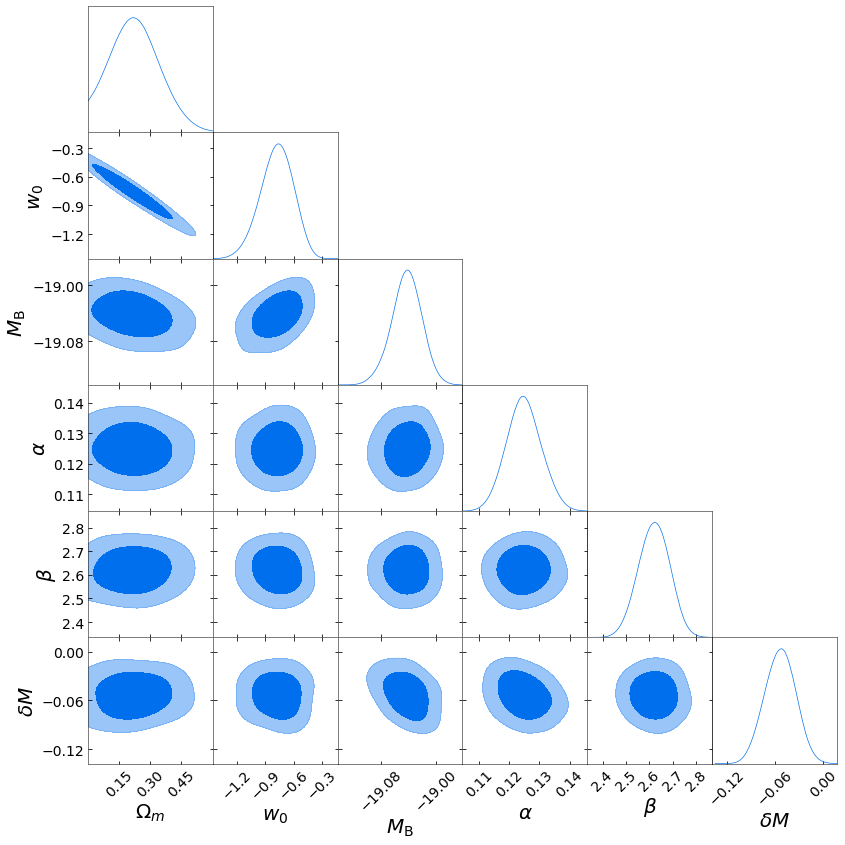

In [16]:
# Do the Fisher pre-training
Delfi.fisher_pretraining(50000, prior, epochs=100, patience=20)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 8.3046, Val_loss: 7.5608
Epoch 00001, Train_loss: 7.6683, Val_loss: 7.1608
Epoch 00002, Train_loss: 7.3112, Val_loss: 6.8231
Epoch 00003, Train_loss: 7.1669, Val_loss: 6.7359
Epoch 00004, Train_loss: 7.0640, Val_loss: 6.6870
Epoch 00005, Train_loss: 7.0059, Val_loss: 6.6614
Epoch 00006, Train_loss: 6.9617, Val_loss: 6.6706
Epoch 00007, Train_loss: 6.9175, Val_loss: 6.6294
Epoch 00008, Train_loss: 6.8829, Val_loss: 6.5876
Epoch 00009, Train_loss: 6.8589, Val_loss: 6.6259
Epoch 00010, Train_loss: 6.8269, Val_loss: 6.5604
Epoch 00011, Train_loss: 6.7939, Val_loss: 6.5927
Epoch 00012, Train_loss: 6.7641, Val_loss: 6.5638
Epoch 00013, Train_loss: 6.7368, Val_loss: 6.5486
Epoch 00014, Train_loss: 6.7031, Val_loss: 6.5183
Epoch 00015, Train_loss: 6.6786, Val_loss: 6.4865
Epoch 00016, Train_loss: 6.6494, Val_loss: 6.4719
Epoch 00017, Train_loss: 6.6215, Val_loss: 6.4540
Epoch 00018, Train_loss: 6.5949, Val_loss: 6.4648
Epoch 00019, Tra

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_0.pdf


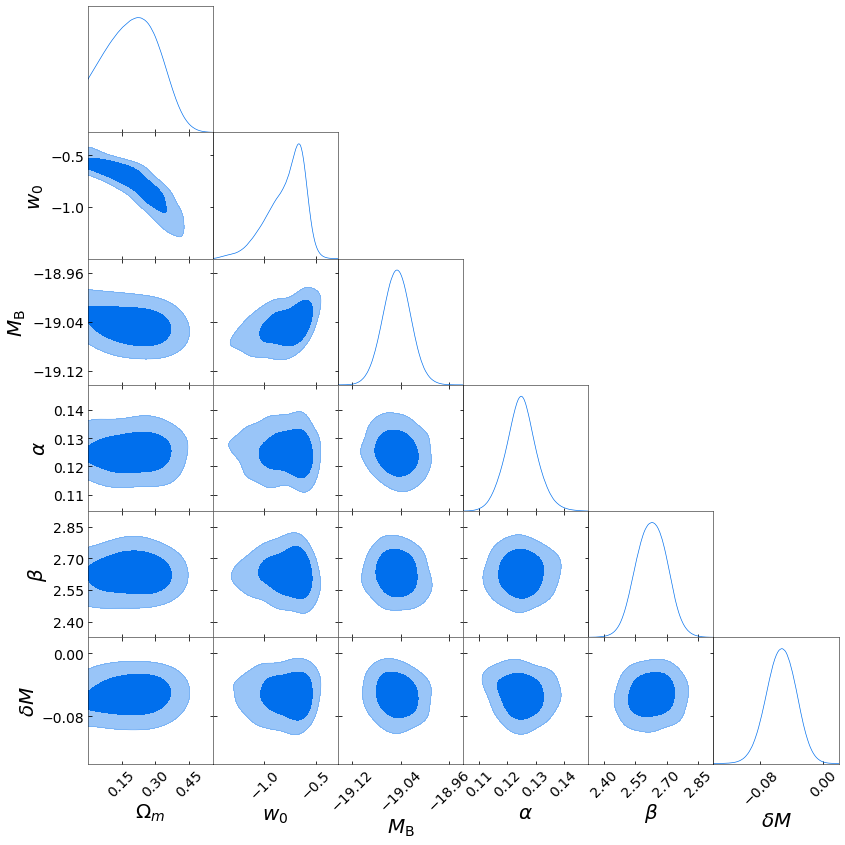

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3209, Val_loss: 6.3880
Epoch 00001, Train_loss: 6.2898, Val_loss: 6.3578
Epoch 00002, Train_loss: 6.2778, Val_loss: 6.3699
Epoch 00003, Train_loss: 6.2659, Val_loss: 6.3514
Epoch 00004, Train_loss: 6.2537, Val_loss: 6.3615
Epoch 00005, Train_loss: 6.2464, Val_loss: 6.3487
Epoch 00006, Train_loss: 6.2422, Val_loss: 6.3561
Epoch 00007, Train_loss: 6.2434, Val_loss: 6.3672
Epoch 00008, Train_loss: 6.2337, Val_loss: 6.3376
Epoch 00009, Train_loss: 6.2267, Val_loss: 6.3545
Epoch 00010, Train_loss: 6.2279, Val_loss: 6.3397
Epoch 00011, Train_loss: 6.2221, Val_loss: 6.3540
Epoch 00012, Train_loss: 6.2160, Val_loss: 6.3396
Epoch 00013, Train_loss: 6.2135, Val_loss: 6.3446
Epoch 00014, Train_loss: 6.2113, Val_loss: 6.3300
Epoch 00015, Train_loss: 6.2125, Val_loss: 6.3537
Epoch 00016, Train_loss: 6.2045, Val_loss: 6.3376
Epoch 00017, Train_loss: 6.2026, Val_loss: 6.3360
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_1.pdf


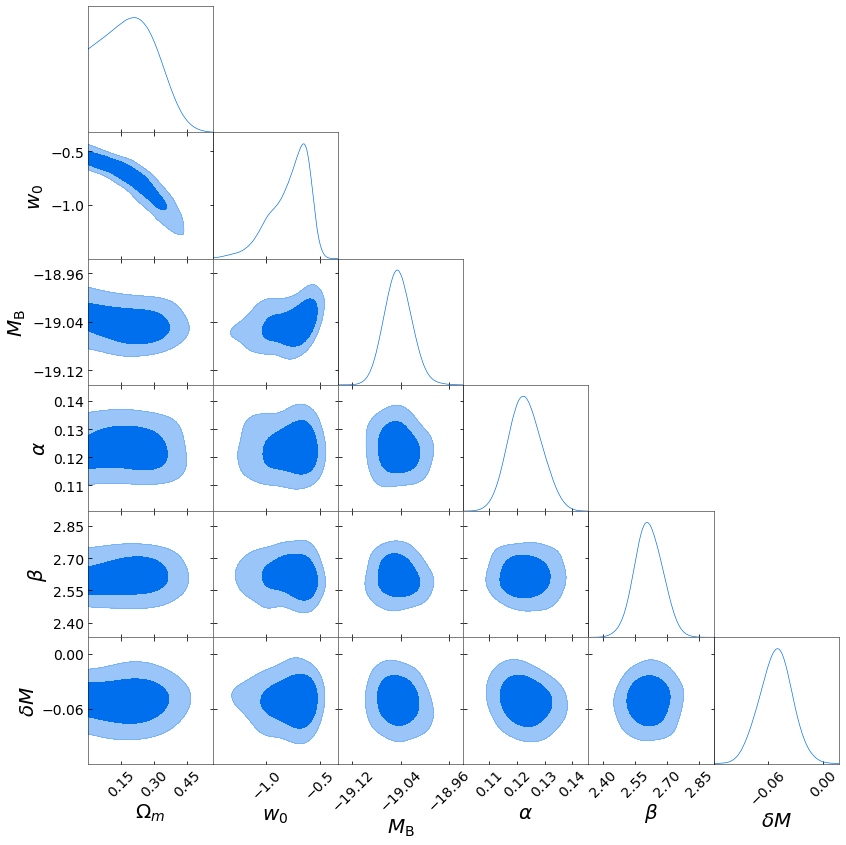

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


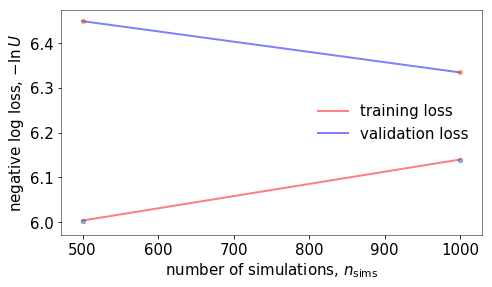

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2610, Val_loss: 6.4080
Epoch 00001, Train_loss: 6.2488, Val_loss: 6.3979
Epoch 00002, Train_loss: 6.2314, Val_loss: 6.4104
Epoch 00003, Train_loss: 6.2288, Val_loss: 6.4201
Epoch 00004, Train_loss: 6.2237, Val_loss: 6.4235
Epoch 00005, Train_loss: 6.2243, Val_loss: 6.4394
Epoch 00006, Train_loss: 6.2144, Val_loss: 6.4316
Epoch 00007, Train_loss: 6.2111, Val_loss: 6.4317
Epoch 00008, Train_loss: 6.2078, Val_loss: 6.4273
Epoch 00009, Train_loss: 6.2046, Val_loss: 6.4332
Epoch 00010, Train_loss: 6.2056, Val_loss: 6.4555
Epoch 00011, Train_loss: 6.2063, Val_loss: 6.4378
Epoch 00012, Train_loss: 6.2006, Val_loss: 6.4295
Epoch 00013, Train_loss: 6.1981, Val_loss: 6.4604
Epoch 00014, Train_loss: 6.1984, Val_loss: 6.4576
Epoch 00015, Train_loss: 6.1965, Val_loss: 6.4408
Epoch 00016, Train_loss: 6.1924, Val_loss: 6.4527
Epoch 00017, Train_loss: 6.1929, Val_loss: 6.4659
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_2.pdf


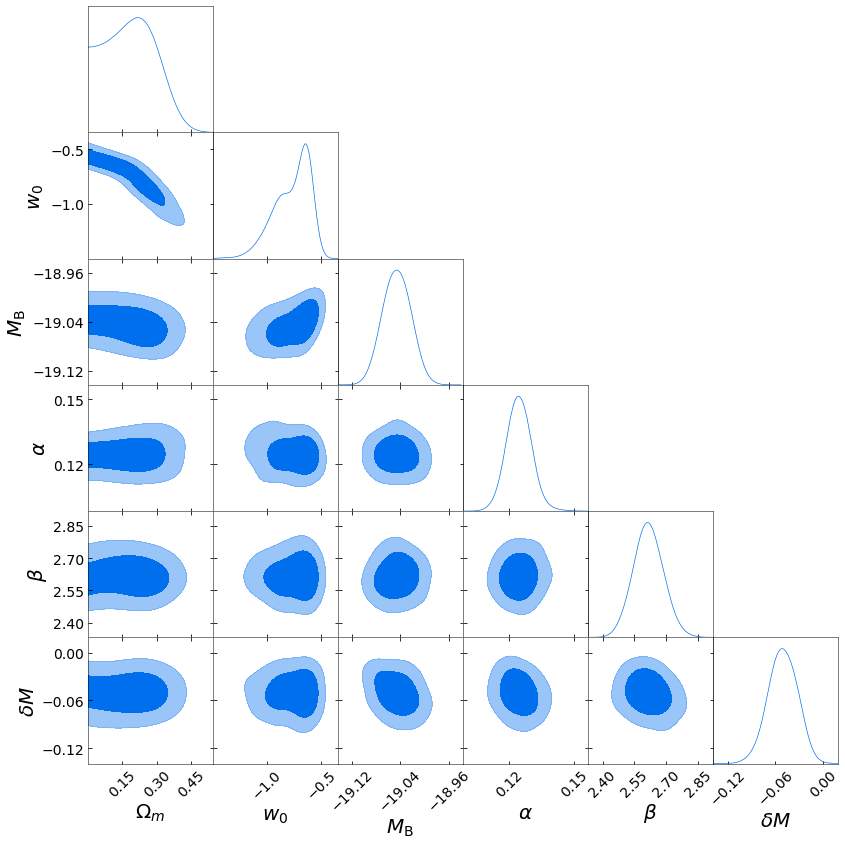

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


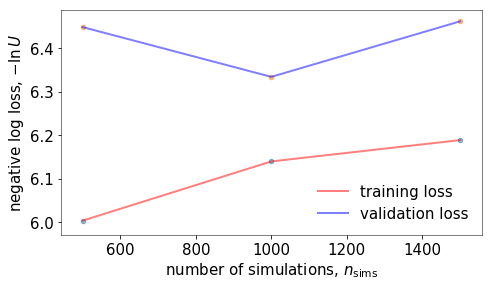

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3233, Val_loss: 6.1735
Epoch 00001, Train_loss: 6.3038, Val_loss: 6.1570
Epoch 00002, Train_loss: 6.2911, Val_loss: 6.1644
Epoch 00003, Train_loss: 6.2875, Val_loss: 6.1840
Epoch 00004, Train_loss: 6.2766, Val_loss: 6.1652
Epoch 00005, Train_loss: 6.2715, Val_loss: 6.1739
Epoch 00006, Train_loss: 6.2691, Val_loss: 6.1733
Epoch 00007, Train_loss: 6.2705, Val_loss: 6.1706
Epoch 00008, Train_loss: 6.2675, Val_loss: 6.1863
Epoch 00009, Train_loss: 6.2576, Val_loss: 6.1715
Epoch 00010, Train_loss: 6.2586, Val_loss: 6.1799
Epoch 00011, Train_loss: 6.2526, Val_loss: 6.1739
Epoch 00012, Train_loss: 6.2487, Val_loss: 6.1768
Epoch 00013, Train_loss: 6.2500, Val_loss: 6.1828
Epoch 00014, Train_loss: 6.2496, Val_loss: 6.1596
Epoch 00015, Train_loss: 6.2422, Val_loss: 6.1798
Epoch 00016, Train_loss: 6.2405, Val_loss: 6.1607
Epoch 00017, Train_loss: 6.2393, Val_loss: 6.1671
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_3.pdf


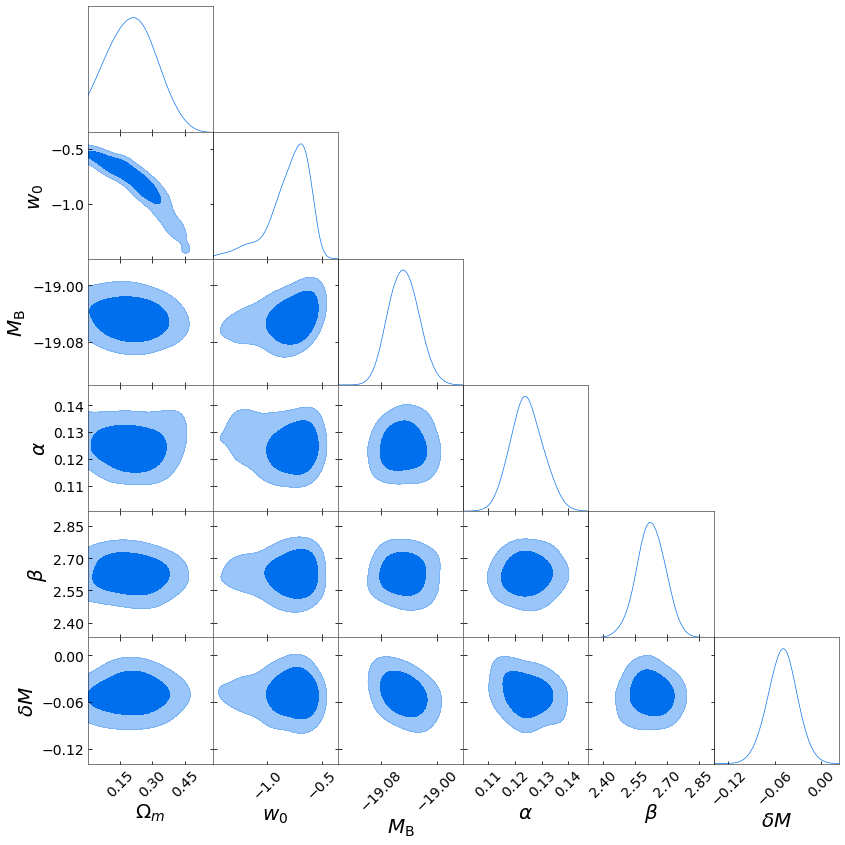

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


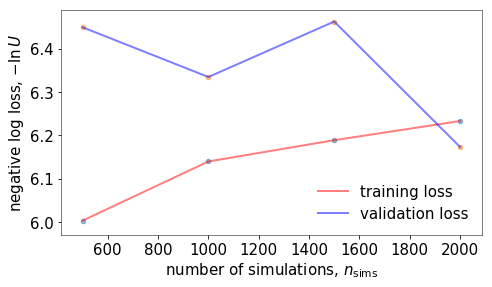

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2974, Val_loss: 6.3281
Epoch 00001, Train_loss: 6.2872, Val_loss: 6.3284
Epoch 00002, Train_loss: 6.2826, Val_loss: 6.3289
Epoch 00003, Train_loss: 6.2709, Val_loss: 6.3301
Epoch 00004, Train_loss: 6.2660, Val_loss: 6.3322
Epoch 00005, Train_loss: 6.2635, Val_loss: 6.3332
Epoch 00006, Train_loss: 6.2601, Val_loss: 6.3306
Epoch 00007, Train_loss: 6.2543, Val_loss: 6.3248
Epoch 00008, Train_loss: 6.2504, Val_loss: 6.3308
Epoch 00009, Train_loss: 6.2464, Val_loss: 6.3224
Epoch 00010, Train_loss: 6.2448, Val_loss: 6.3198
Epoch 00011, Train_loss: 6.2427, Val_loss: 6.3215
Epoch 00012, Train_loss: 6.2381, Val_loss: 6.3165
Epoch 00013, Train_loss: 6.2387, Val_loss: 6.3230
Epoch 00014, Train_loss: 6.2343, Val_loss: 6.3213
Epoch 00015, Train_loss: 6.2344, Val_loss: 6.3150
Epoch 00016, Train_loss: 6.2334, Val_loss: 6.3290
Epoch 00017, Train_loss: 6.2330, Val_loss: 6.3050
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_4.pdf


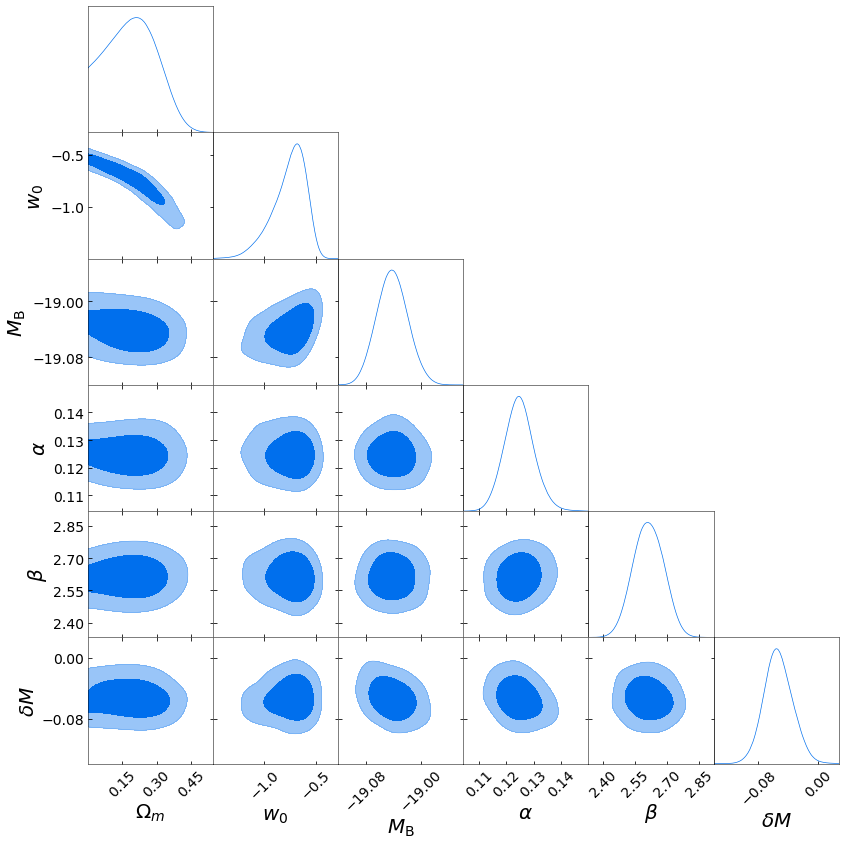

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


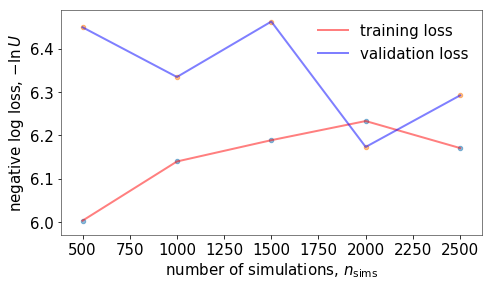

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2175, Val_loss: 6.2324
Epoch 00001, Train_loss: 6.2069, Val_loss: 6.2376
Epoch 00002, Train_loss: 6.2034, Val_loss: 6.2400
Epoch 00003, Train_loss: 6.2039, Val_loss: 6.2446
Epoch 00004, Train_loss: 6.2006, Val_loss: 6.2445
Epoch 00005, Train_loss: 6.2019, Val_loss: 6.2499
Epoch 00006, Train_loss: 6.1970, Val_loss: 6.2490
Epoch 00007, Train_loss: 6.1960, Val_loss: 6.2458
Epoch 00008, Train_loss: 6.1942, Val_loss: 6.2489
Epoch 00009, Train_loss: 6.1932, Val_loss: 6.2528
Epoch 00010, Train_loss: 6.1925, Val_loss: 6.2551
Epoch 00011, Train_loss: 6.1957, Val_loss: 6.2635
Epoch 00012, Train_loss: 6.1907, Val_loss: 6.2516
Epoch 00013, Train_loss: 6.1893, Val_loss: 6.2590
Epoch 00014, Train_loss: 6.1879, Val_loss: 6.2535
Epoch 00015, Train_loss: 6.1886, Val_loss: 6.2612
Epoch 00016, Train_loss: 6.1899, Val_loss: 6.2547
Epoch 00017, Train_loss: 6.1952, Val_loss: 6.2707
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_5.pdf


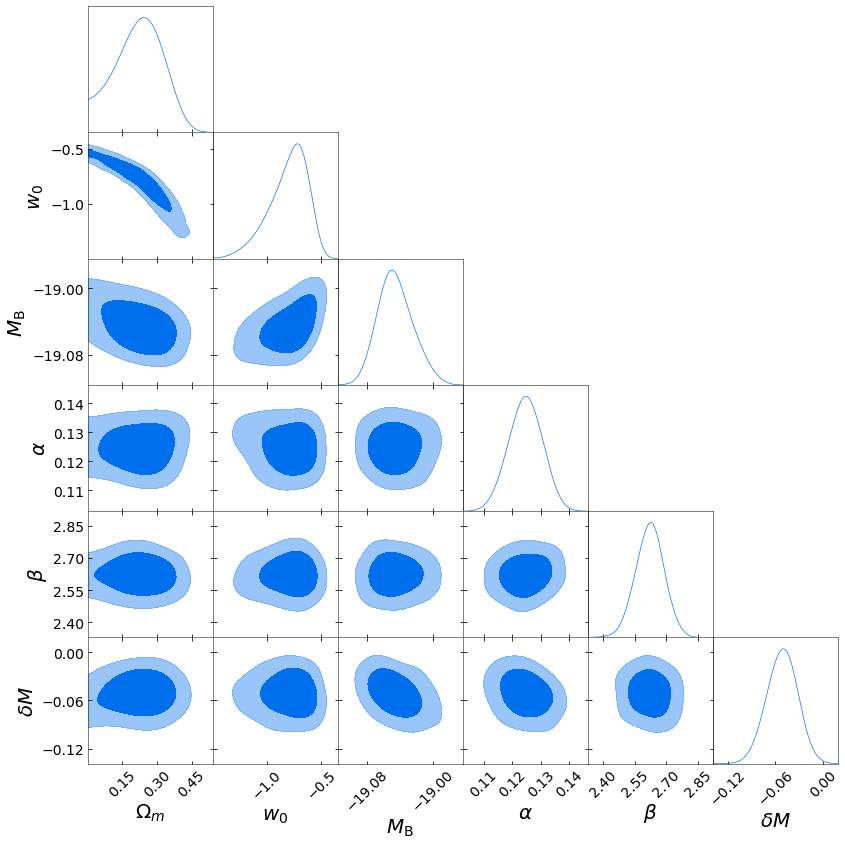

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


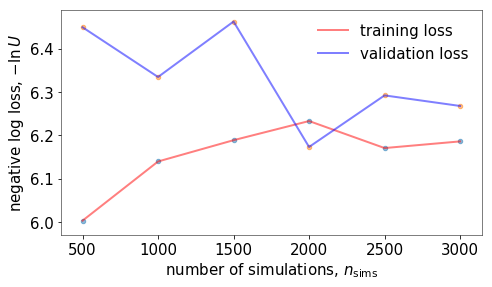

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2412, Val_loss: 6.1786
Epoch 00001, Train_loss: 6.2361, Val_loss: 6.1918
Epoch 00002, Train_loss: 6.2338, Val_loss: 6.1932
Epoch 00003, Train_loss: 6.2315, Val_loss: 6.1907
Epoch 00004, Train_loss: 6.2303, Val_loss: 6.2008
Epoch 00005, Train_loss: 6.2285, Val_loss: 6.2034
Epoch 00006, Train_loss: 6.2264, Val_loss: 6.1915
Epoch 00007, Train_loss: 6.2271, Val_loss: 6.1909
Epoch 00008, Train_loss: 6.2254, Val_loss: 6.1974
Epoch 00009, Train_loss: 6.2231, Val_loss: 6.2017
Epoch 00010, Train_loss: 6.2224, Val_loss: 6.1935
Epoch 00011, Train_loss: 6.2214, Val_loss: 6.1936
Epoch 00012, Train_loss: 6.2197, Val_loss: 6.1971
Epoch 00013, Train_loss: 6.2220, Val_loss: 6.2139
Epoch 00014, Train_loss: 6.2181, Val_loss: 6.2024
Epoch 00015, Train_loss: 6.2170, Val_loss: 6.1958
Epoch 00016, Train_loss: 6.2172, Val_loss: 6.1951
Epoch 00017, Train_loss: 6.2163, Val_loss: 6.1969
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_6.pdf


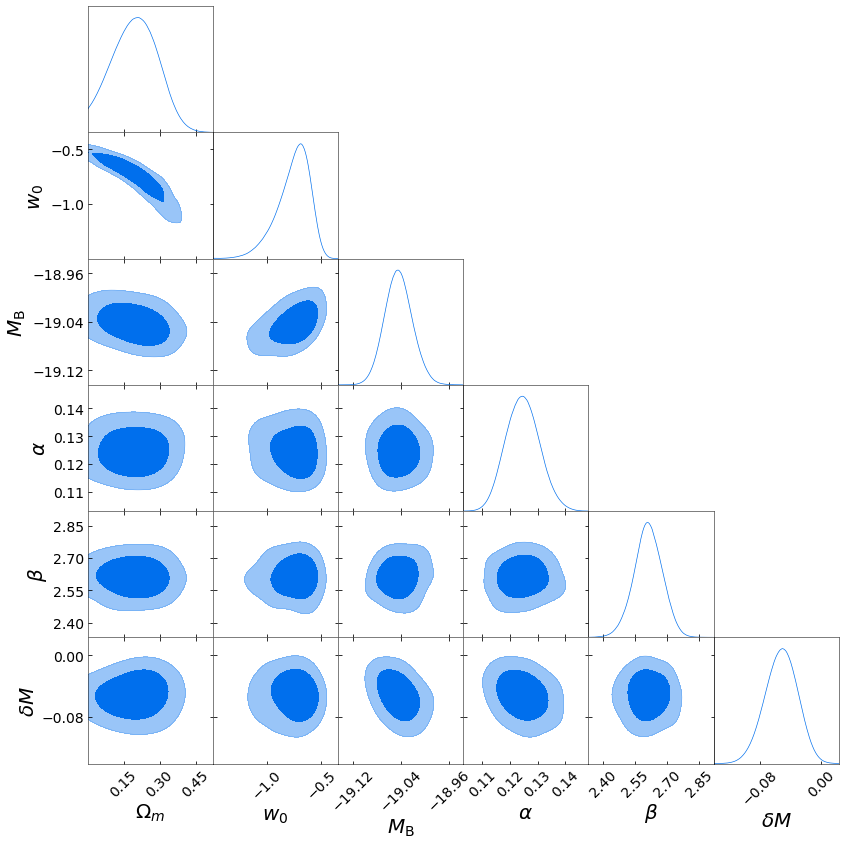

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


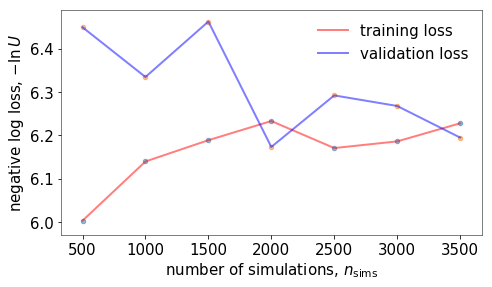

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2505, Val_loss: 6.2046
Epoch 00001, Train_loss: 6.2436, Val_loss: 6.1996
Epoch 00002, Train_loss: 6.2404, Val_loss: 6.2009
Epoch 00003, Train_loss: 6.2379, Val_loss: 6.2031
Epoch 00004, Train_loss: 6.2376, Val_loss: 6.2045
Epoch 00005, Train_loss: 6.2347, Val_loss: 6.2065
Epoch 00006, Train_loss: 6.2341, Val_loss: 6.2057
Epoch 00007, Train_loss: 6.2337, Val_loss: 6.2087
Epoch 00008, Train_loss: 6.2310, Val_loss: 6.2052
Epoch 00009, Train_loss: 6.2316, Val_loss: 6.2106
Epoch 00010, Train_loss: 6.2283, Val_loss: 6.2083
Epoch 00011, Train_loss: 6.2300, Val_loss: 6.2032
Epoch 00012, Train_loss: 6.2306, Val_loss: 6.2092
Epoch 00013, Train_loss: 6.2258, Val_loss: 6.2100
Epoch 00014, Train_loss: 6.2314, Val_loss: 6.2189
Epoch 00015, Train_loss: 6.2258, Val_loss: 6.2085
Epoch 00016, Train_loss: 6.2392, Val_loss: 6.2208
Epoch 00017, Train_loss: 6.2225, Val_loss: 6.2094
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_7.pdf


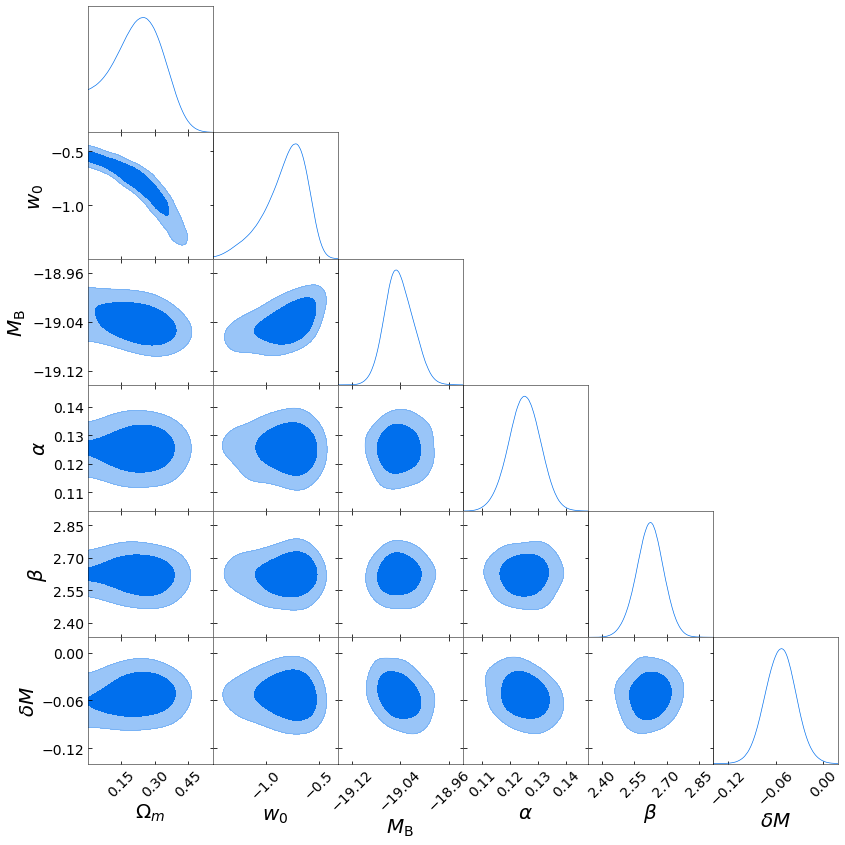

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


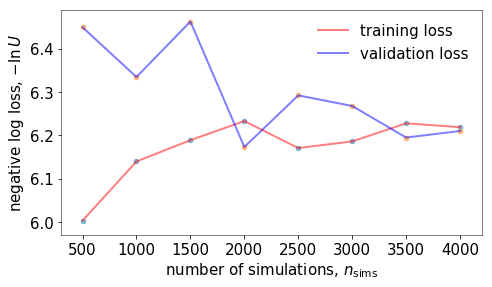

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2510, Val_loss: 6.2152
Epoch 00001, Train_loss: 6.2482, Val_loss: 6.2150
Epoch 00002, Train_loss: 6.2456, Val_loss: 6.2211
Epoch 00003, Train_loss: 6.2424, Val_loss: 6.2227
Epoch 00004, Train_loss: 6.2413, Val_loss: 6.2197
Epoch 00005, Train_loss: 6.2394, Val_loss: 6.2243
Epoch 00006, Train_loss: 6.2378, Val_loss: 6.2208
Epoch 00007, Train_loss: 6.2365, Val_loss: 6.2239
Epoch 00008, Train_loss: 6.2384, Val_loss: 6.2273
Epoch 00009, Train_loss: 6.2347, Val_loss: 6.2262
Epoch 00010, Train_loss: 6.2330, Val_loss: 6.2190
Epoch 00011, Train_loss: 6.2314, Val_loss: 6.2209
Epoch 00012, Train_loss: 6.2302, Val_loss: 6.2243
Epoch 00013, Train_loss: 6.2325, Val_loss: 6.2301
Epoch 00014, Train_loss: 6.2299, Val_loss: 6.2246
Epoch 00015, Train_loss: 6.2287, Val_loss: 6.2241
Epoch 00016, Train_loss: 6.2305, Val_loss: 6.2287
Epoch 00017, Train_loss: 6.2344, Val_loss: 6.2304
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_8.pdf


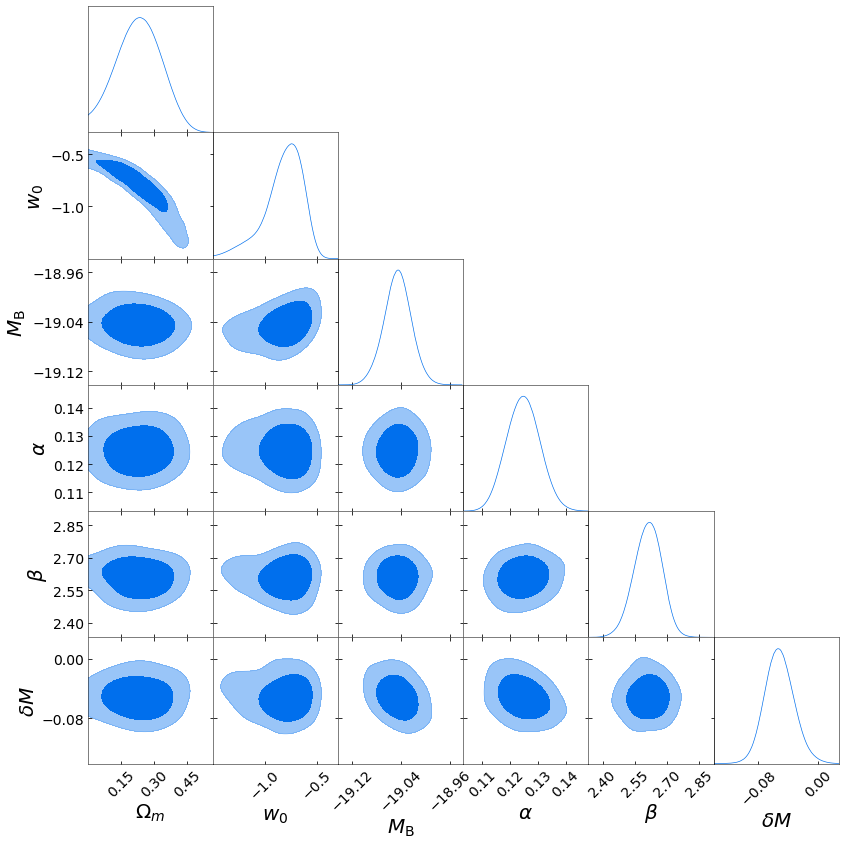

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


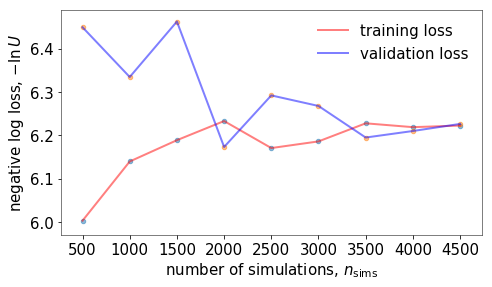

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2661, Val_loss: 6.1717
Epoch 00001, Train_loss: 6.2640, Val_loss: 6.1834
Epoch 00002, Train_loss: 6.2605, Val_loss: 6.1809
Epoch 00003, Train_loss: 6.2577, Val_loss: 6.1802
Epoch 00004, Train_loss: 6.2562, Val_loss: 6.1841
Epoch 00005, Train_loss: 6.2545, Val_loss: 6.1853
Epoch 00006, Train_loss: 6.2533, Val_loss: 6.1850
Epoch 00007, Train_loss: 6.2515, Val_loss: 6.1852
Epoch 00008, Train_loss: 6.2506, Val_loss: 6.1835
Epoch 00009, Train_loss: 6.2501, Val_loss: 6.1876
Epoch 00010, Train_loss: 6.2492, Val_loss: 6.1901
Epoch 00011, Train_loss: 6.2480, Val_loss: 6.1884
Epoch 00012, Train_loss: 6.2467, Val_loss: 6.1879
Epoch 00013, Train_loss: 6.2449, Val_loss: 6.1870
Epoch 00014, Train_loss: 6.2438, Val_loss: 6.1850
Epoch 00015, Train_loss: 6.2459, Val_loss: 6.1917
Epoch 00016, Train_loss: 6.2433, Val_loss: 6.1924
Epoch 00017, Train_loss: 6.2413, Val_loss: 6.1869
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_9.pdf


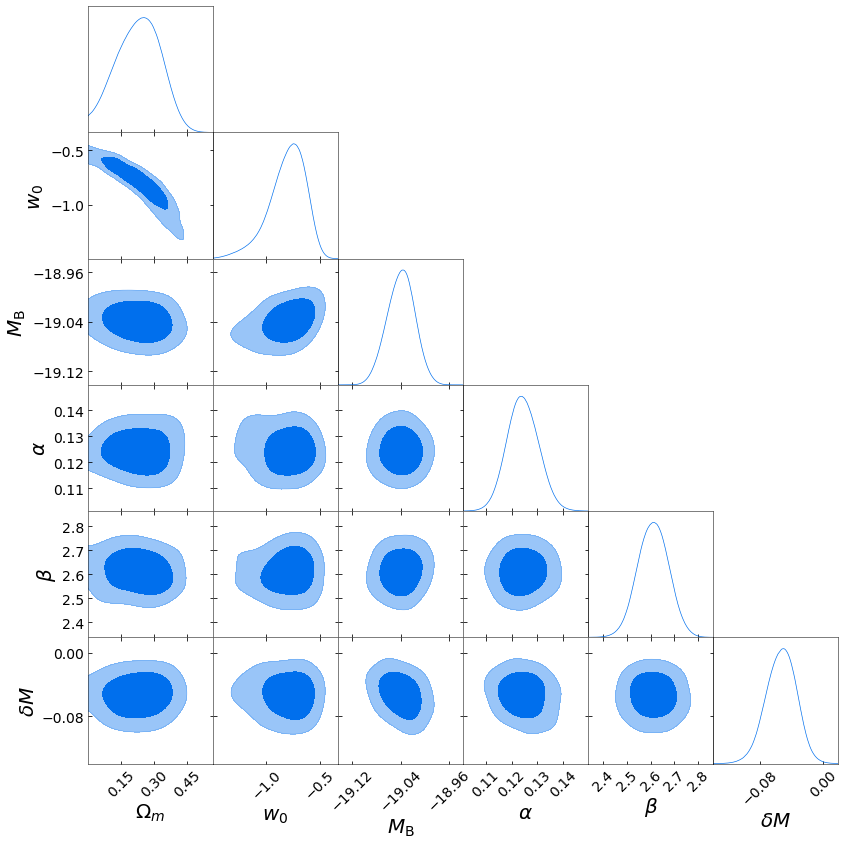

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


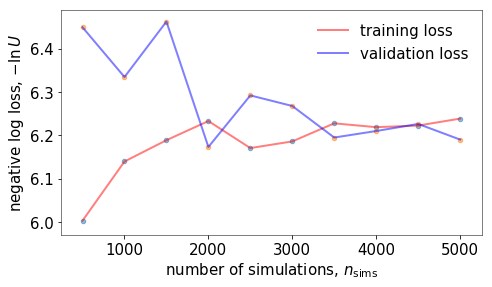

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2809, Val_loss: 6.2246
Epoch 00001, Train_loss: 6.2747, Val_loss: 6.2341
Epoch 00002, Train_loss: 6.2718, Val_loss: 6.2324
Epoch 00003, Train_loss: 6.2705, Val_loss: 6.2338
Epoch 00004, Train_loss: 6.2666, Val_loss: 6.2376
Epoch 00005, Train_loss: 6.2655, Val_loss: 6.2407
Epoch 00006, Train_loss: 6.2640, Val_loss: 6.2375
Epoch 00007, Train_loss: 6.2630, Val_loss: 6.2387
Epoch 00008, Train_loss: 6.2607, Val_loss: 6.2417
Epoch 00009, Train_loss: 6.2625, Val_loss: 6.2454
Epoch 00010, Train_loss: 6.2576, Val_loss: 6.2411
Epoch 00011, Train_loss: 6.2573, Val_loss: 6.2434
Epoch 00012, Train_loss: 6.2568, Val_loss: 6.2447
Epoch 00013, Train_loss: 6.2574, Val_loss: 6.2400
Epoch 00014, Train_loss: 6.2609, Val_loss: 6.2389
Epoch 00015, Train_loss: 6.2528, Val_loss: 6.2432
Epoch 00016, Train_loss: 6.2565, Val_loss: 6.2528
Epoch 00017, Train_loss: 6.2537, Val_loss: 6.2465
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_10.pdf


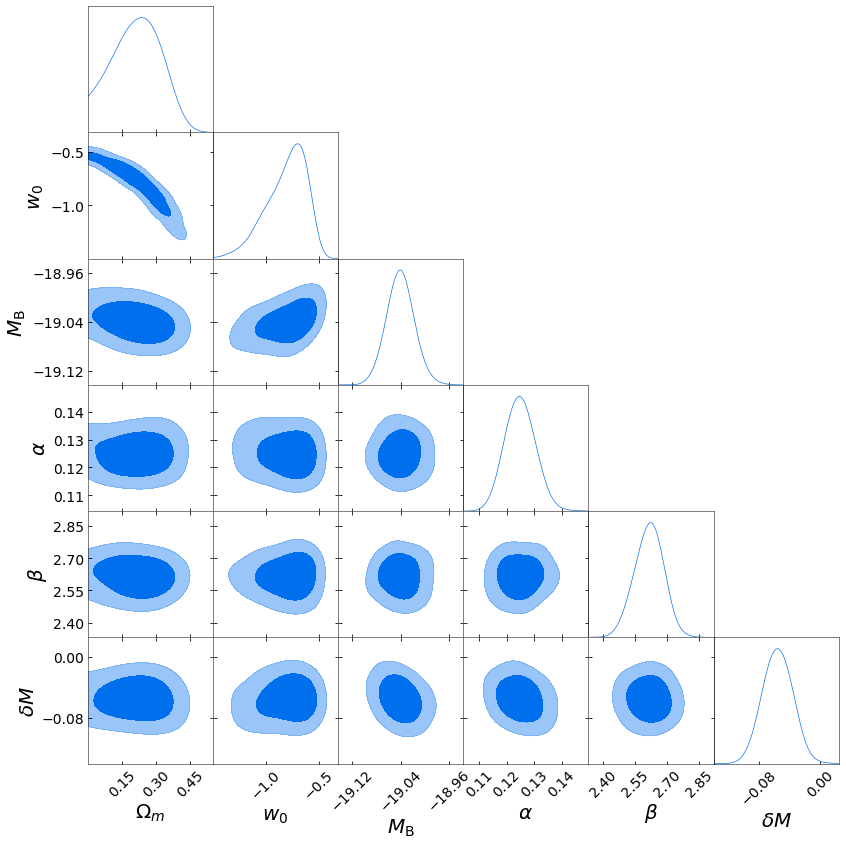

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


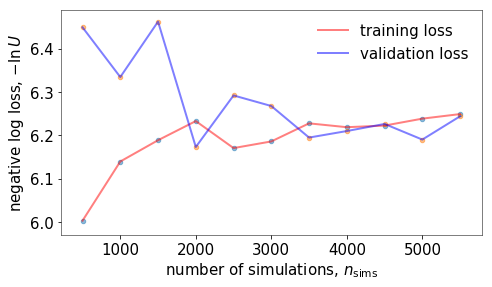

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2887, Val_loss: 6.2296
Epoch 00001, Train_loss: 6.2849, Val_loss: 6.2355
Epoch 00002, Train_loss: 6.2826, Val_loss: 6.2385
Epoch 00003, Train_loss: 6.2804, Val_loss: 6.2376
Epoch 00004, Train_loss: 6.2783, Val_loss: 6.2373
Epoch 00005, Train_loss: 6.2774, Val_loss: 6.2379
Epoch 00006, Train_loss: 6.2763, Val_loss: 6.2416
Epoch 00007, Train_loss: 6.2744, Val_loss: 6.2375
Epoch 00008, Train_loss: 6.2740, Val_loss: 6.2377
Epoch 00009, Train_loss: 6.2719, Val_loss: 6.2399
Epoch 00010, Train_loss: 6.2706, Val_loss: 6.2368
Epoch 00011, Train_loss: 6.2695, Val_loss: 6.2401
Epoch 00012, Train_loss: 6.2699, Val_loss: 6.2398
Epoch 00013, Train_loss: 6.2696, Val_loss: 6.2376
Epoch 00014, Train_loss: 6.2672, Val_loss: 6.2390
Epoch 00015, Train_loss: 6.2651, Val_loss: 6.2373
Epoch 00016, Train_loss: 6.2645, Val_loss: 6.2395
Epoch 00017, Train_loss: 6.2637, Val_loss: 6.2360
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_11.pdf


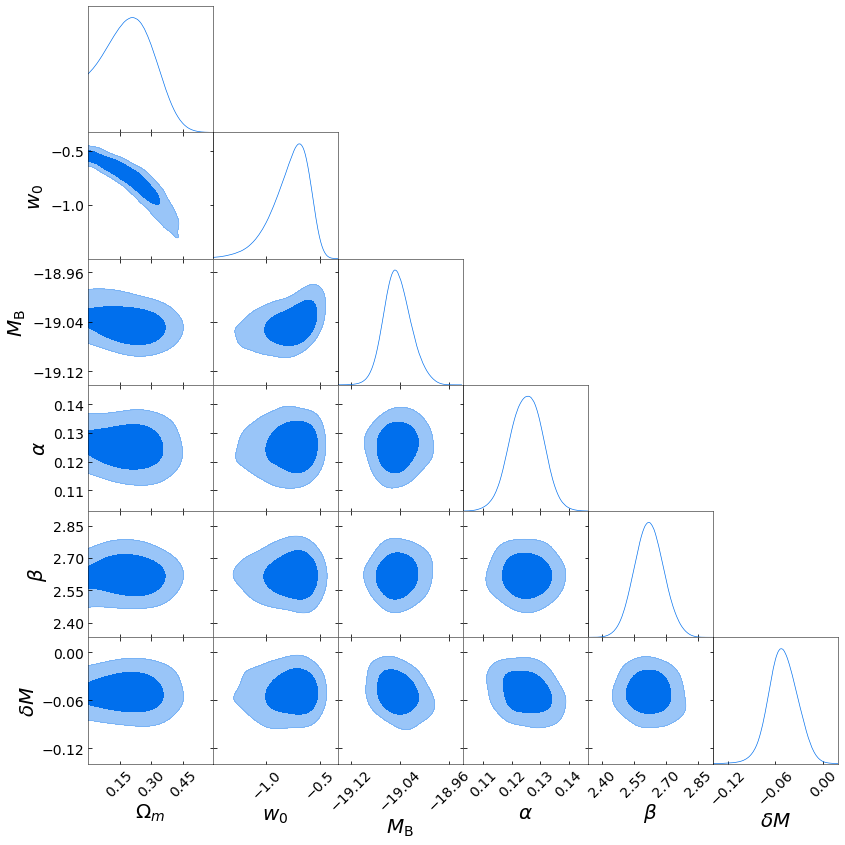

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


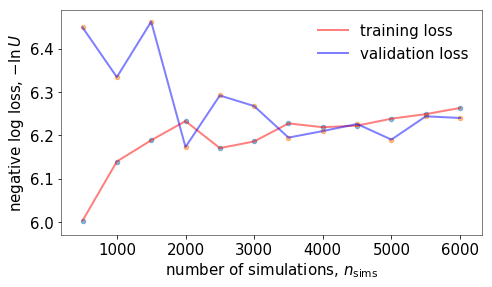

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2927, Val_loss: 6.4021
Epoch 00001, Train_loss: 6.2891, Val_loss: 6.4051
Epoch 00002, Train_loss: 6.2853, Val_loss: 6.4040
Epoch 00003, Train_loss: 6.2841, Val_loss: 6.4091
Epoch 00004, Train_loss: 6.2821, Val_loss: 6.4062
Epoch 00005, Train_loss: 6.2832, Val_loss: 6.4081
Epoch 00006, Train_loss: 6.2802, Val_loss: 6.4099
Epoch 00007, Train_loss: 6.2762, Val_loss: 6.4064
Epoch 00008, Train_loss: 6.2754, Val_loss: 6.4060
Epoch 00009, Train_loss: 6.2739, Val_loss: 6.4049
Epoch 00010, Train_loss: 6.2739, Val_loss: 6.4089
Epoch 00011, Train_loss: 6.2712, Val_loss: 6.4056
Epoch 00012, Train_loss: 6.2720, Val_loss: 6.4078
Epoch 00013, Train_loss: 6.2691, Val_loss: 6.4046
Epoch 00014, Train_loss: 6.2675, Val_loss: 6.4080
Epoch 00015, Train_loss: 6.2668, Val_loss: 6.4069
Epoch 00016, Train_loss: 6.2660, Val_loss: 6.4052
Epoch 00017, Train_loss: 6.2650, Val_loss: 6.4046
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_12.pdf


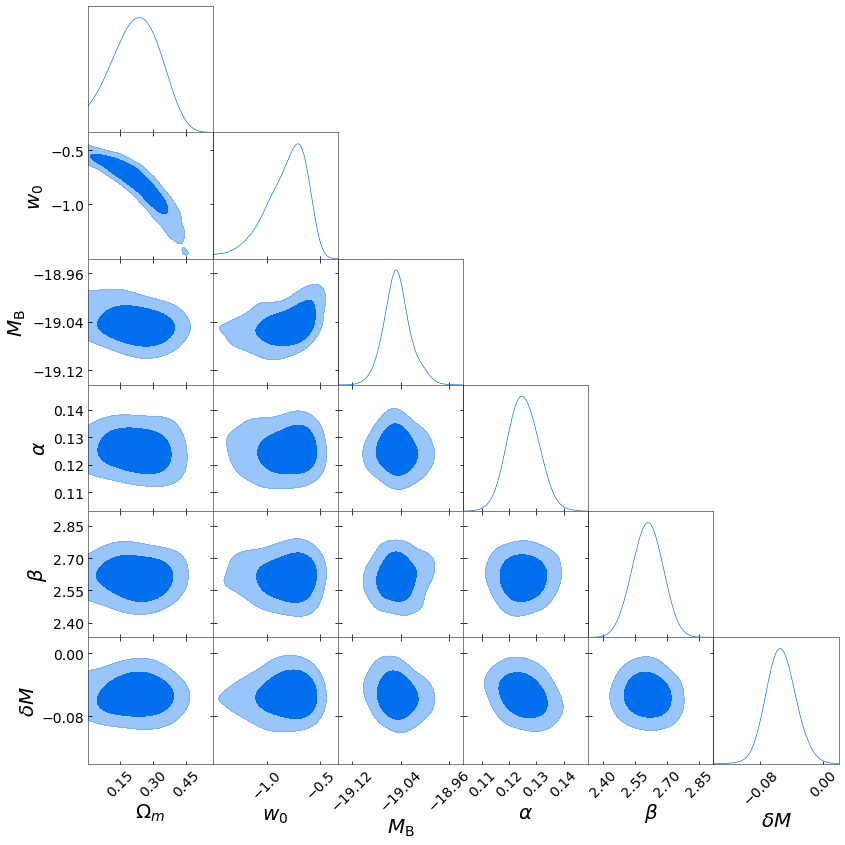

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


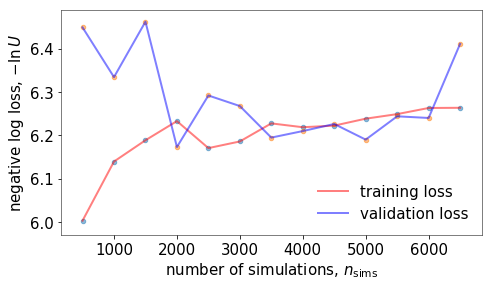

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3125, Val_loss: 6.2390
Epoch 00001, Train_loss: 6.3090, Val_loss: 6.2386
Epoch 00002, Train_loss: 6.3066, Val_loss: 6.2416
Epoch 00003, Train_loss: 6.3042, Val_loss: 6.2418
Epoch 00004, Train_loss: 6.3024, Val_loss: 6.2420
Epoch 00005, Train_loss: 6.3008, Val_loss: 6.2403
Epoch 00006, Train_loss: 6.2991, Val_loss: 6.2415
Epoch 00007, Train_loss: 6.2976, Val_loss: 6.2422
Epoch 00008, Train_loss: 6.2973, Val_loss: 6.2449
Epoch 00009, Train_loss: 6.2950, Val_loss: 6.2403
Epoch 00010, Train_loss: 6.2949, Val_loss: 6.2417
Epoch 00011, Train_loss: 6.2940, Val_loss: 6.2478
Epoch 00012, Train_loss: 6.2958, Val_loss: 6.2490
Epoch 00013, Train_loss: 6.2922, Val_loss: 6.2463
Epoch 00014, Train_loss: 6.2892, Val_loss: 6.2438
Epoch 00015, Train_loss: 6.2933, Val_loss: 6.2409
Epoch 00016, Train_loss: 6.2882, Val_loss: 6.2404
Epoch 00017, Train_loss: 6.2870, Val_loss: 6.2440
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_13.pdf


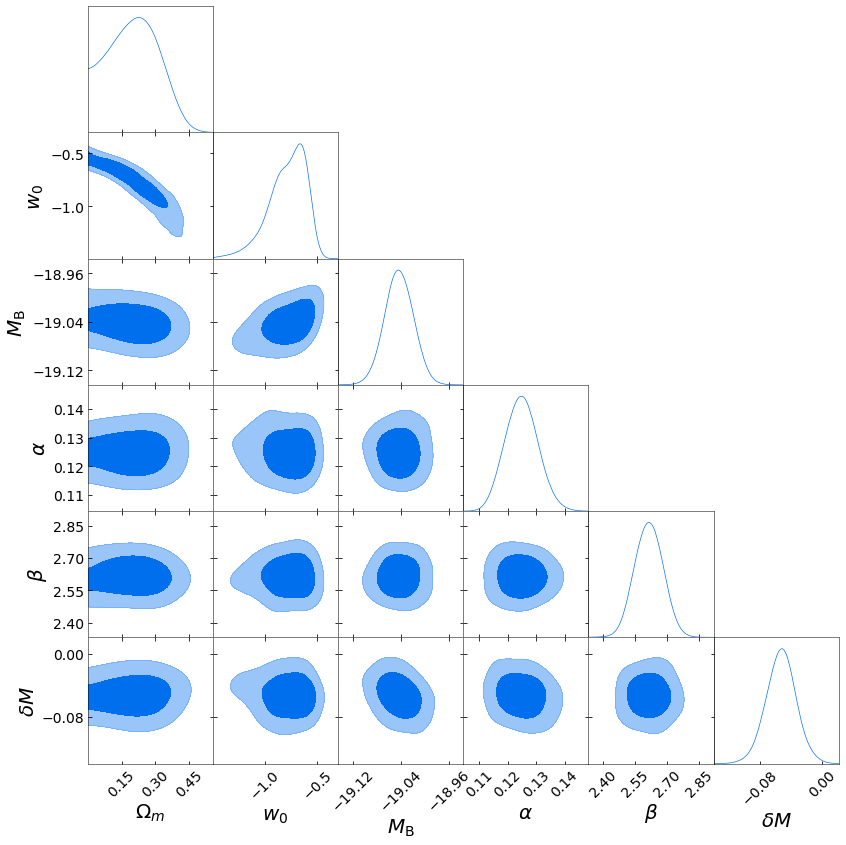

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


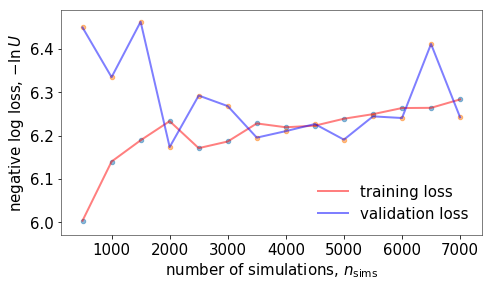

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3167, Val_loss: 6.2254
Epoch 00001, Train_loss: 6.3137, Val_loss: 6.2305
Epoch 00002, Train_loss: 6.3163, Val_loss: 6.2373
Epoch 00003, Train_loss: 6.3100, Val_loss: 6.2318
Epoch 00004, Train_loss: 6.3081, Val_loss: 6.2329
Epoch 00005, Train_loss: 6.3087, Val_loss: 6.2404
Epoch 00006, Train_loss: 6.3066, Val_loss: 6.2354
Epoch 00007, Train_loss: 6.3075, Val_loss: 6.2358
Epoch 00008, Train_loss: 6.3028, Val_loss: 6.2344
Epoch 00009, Train_loss: 6.3009, Val_loss: 6.2337
Epoch 00010, Train_loss: 6.3011, Val_loss: 6.2363
Epoch 00011, Train_loss: 6.2989, Val_loss: 6.2353
Epoch 00012, Train_loss: 6.3009, Val_loss: 6.2333
Epoch 00013, Train_loss: 6.2969, Val_loss: 6.2322
Epoch 00014, Train_loss: 6.2974, Val_loss: 6.2372
Epoch 00015, Train_loss: 6.2954, Val_loss: 6.2353
Epoch 00016, Train_loss: 6.2946, Val_loss: 6.2325
Epoch 00017, Train_loss: 6.2946, Val_loss: 6.2337
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_14.pdf


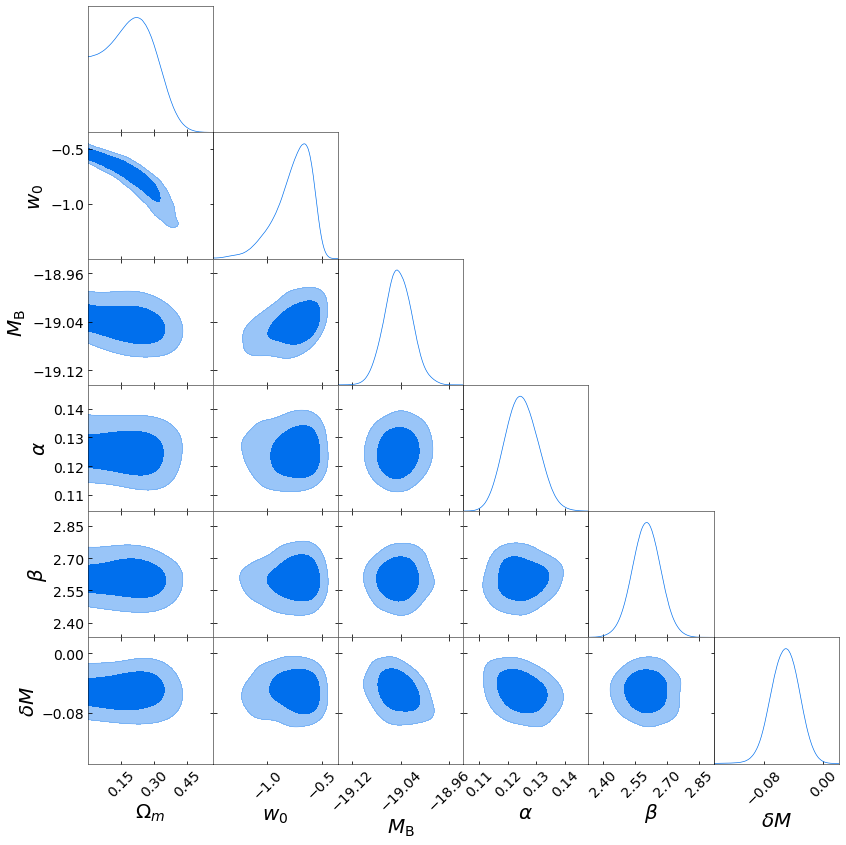

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


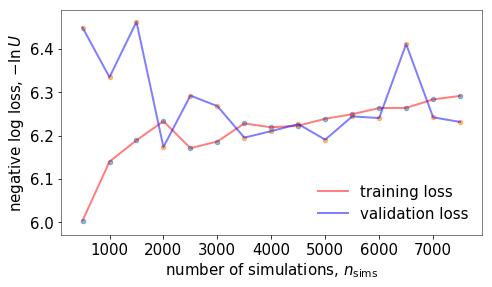

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3201, Val_loss: 6.2863
Epoch 00001, Train_loss: 6.3174, Val_loss: 6.2902
Epoch 00002, Train_loss: 6.3153, Val_loss: 6.2912
Epoch 00003, Train_loss: 6.3172, Val_loss: 6.2905
Epoch 00004, Train_loss: 6.3158, Val_loss: 6.2904
Epoch 00005, Train_loss: 6.3110, Val_loss: 6.2914
Epoch 00006, Train_loss: 6.3105, Val_loss: 6.2952
Epoch 00007, Train_loss: 6.3081, Val_loss: 6.2907
Epoch 00008, Train_loss: 6.3079, Val_loss: 6.2927
Epoch 00009, Train_loss: 6.3059, Val_loss: 6.2890
Epoch 00010, Train_loss: 6.3054, Val_loss: 6.2892
Epoch 00011, Train_loss: 6.3055, Val_loss: 6.2925
Epoch 00012, Train_loss: 6.3029, Val_loss: 6.2910
Epoch 00013, Train_loss: 6.3021, Val_loss: 6.2889
Epoch 00014, Train_loss: 6.3024, Val_loss: 6.2867
Epoch 00015, Train_loss: 6.3012, Val_loss: 6.2856
Epoch 00016, Train_loss: 6.3012, Val_loss: 6.2937
Epoch 00017, Train_loss: 6.3014, Val_loss: 6.2920
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_15.pdf


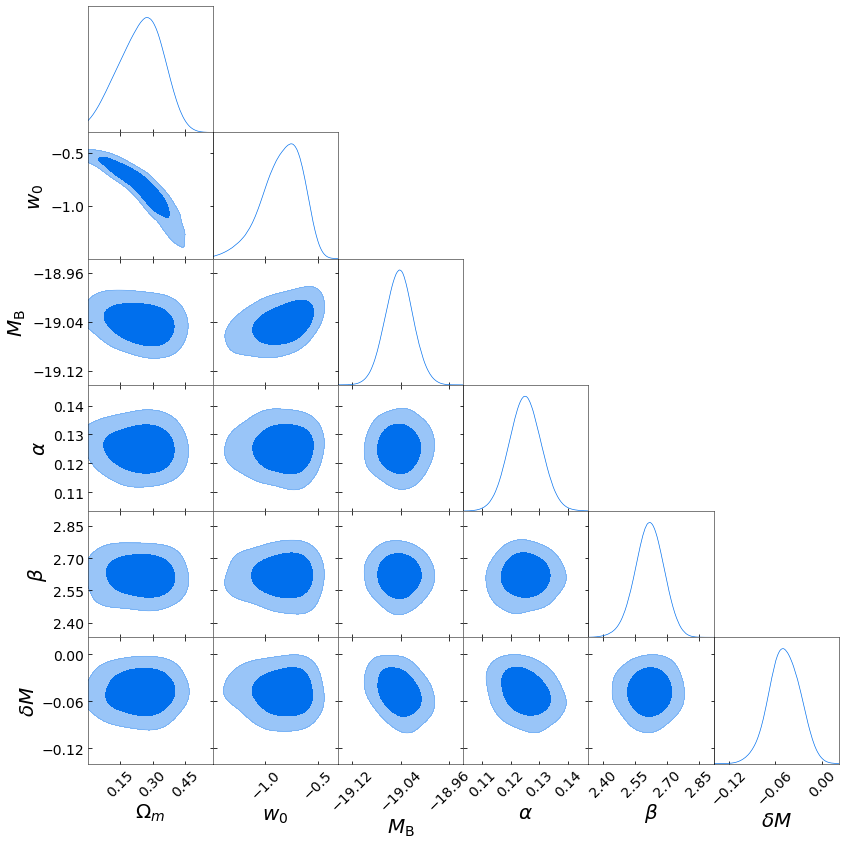

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


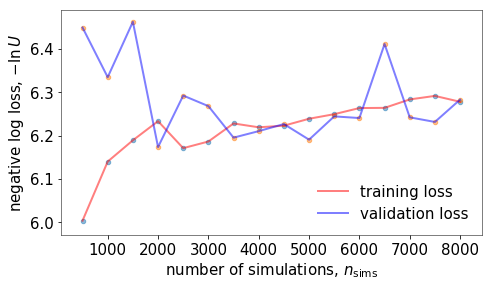

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2830, Val_loss: 6.2419
Epoch 00001, Train_loss: 6.2841, Val_loss: 6.2457
Epoch 00002, Train_loss: 6.2823, Val_loss: 6.2455
Epoch 00003, Train_loss: 6.2815, Val_loss: 6.2485
Epoch 00004, Train_loss: 6.2815, Val_loss: 6.2483
Epoch 00005, Train_loss: 6.2806, Val_loss: 6.2511
Epoch 00006, Train_loss: 6.2799, Val_loss: 6.2491
Epoch 00007, Train_loss: 6.2801, Val_loss: 6.2513
Epoch 00008, Train_loss: 6.2791, Val_loss: 6.2505
Epoch 00009, Train_loss: 6.2822, Val_loss: 6.2563
Epoch 00010, Train_loss: 6.2787, Val_loss: 6.2527
Epoch 00011, Train_loss: 6.2805, Val_loss: 6.2536
Epoch 00012, Train_loss: 6.2798, Val_loss: 6.2527
Epoch 00013, Train_loss: 6.2781, Val_loss: 6.2567
Epoch 00014, Train_loss: 6.2837, Val_loss: 6.2592
Epoch 00015, Train_loss: 6.2789, Val_loss: 6.2584
Epoch 00016, Train_loss: 6.2797, Val_loss: 6.2551
Epoch 00017, Train_loss: 6.2773, Val_loss: 6.2535
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_16.pdf


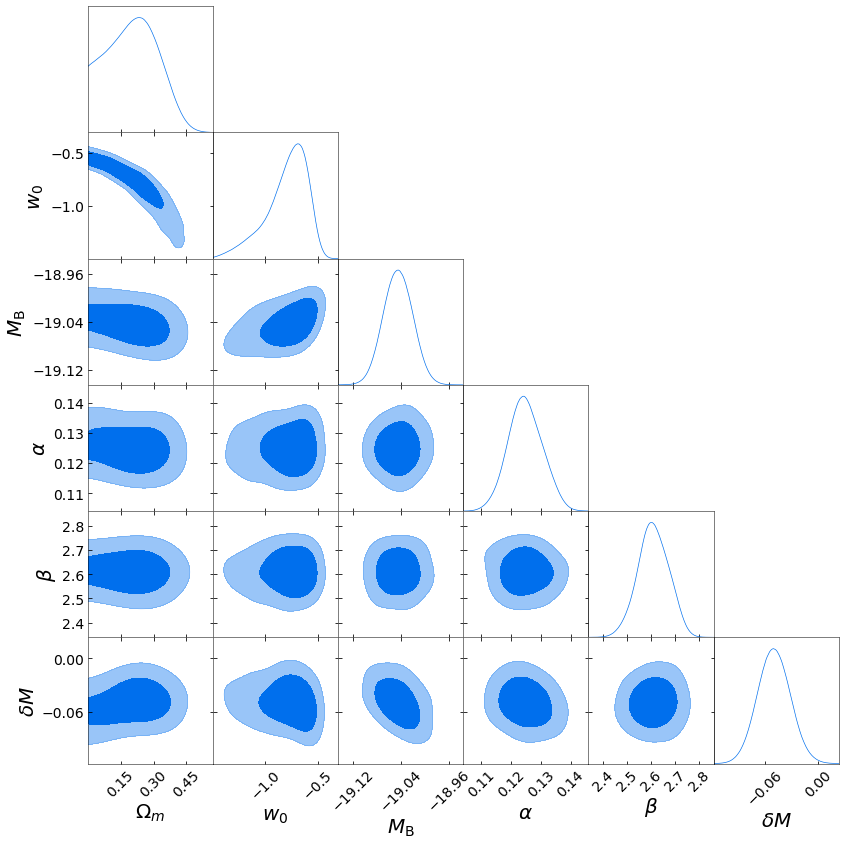

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


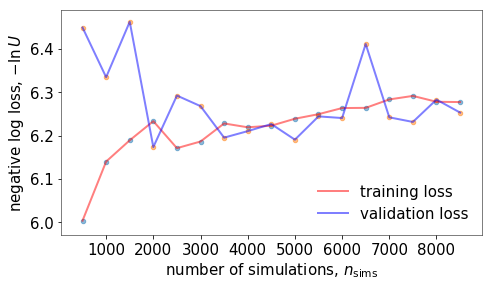

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2715, Val_loss: 6.3485
Epoch 00001, Train_loss: 6.2719, Val_loss: 6.3602
Epoch 00002, Train_loss: 6.2707, Val_loss: 6.3526
Epoch 00003, Train_loss: 6.2702, Val_loss: 6.3627
Epoch 00004, Train_loss: 6.2690, Val_loss: 6.3588
Epoch 00005, Train_loss: 6.2688, Val_loss: 6.3617
Epoch 00006, Train_loss: 6.2706, Val_loss: 6.3617
Epoch 00007, Train_loss: 6.2703, Val_loss: 6.3603
Epoch 00008, Train_loss: 6.2686, Val_loss: 6.3590
Epoch 00009, Train_loss: 6.2668, Val_loss: 6.3626
Epoch 00010, Train_loss: 6.2670, Val_loss: 6.3612
Epoch 00011, Train_loss: 6.2662, Val_loss: 6.3613
Epoch 00012, Train_loss: 6.2666, Val_loss: 6.3608
Epoch 00013, Train_loss: 6.2703, Val_loss: 6.3759
Epoch 00014, Train_loss: 6.2665, Val_loss: 6.3604
Epoch 00015, Train_loss: 6.2656, Val_loss: 6.3688
Epoch 00016, Train_loss: 6.2664, Val_loss: 6.3654
Epoch 00017, Train_loss: 6.2655, Val_loss: 6.3628
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_17.pdf


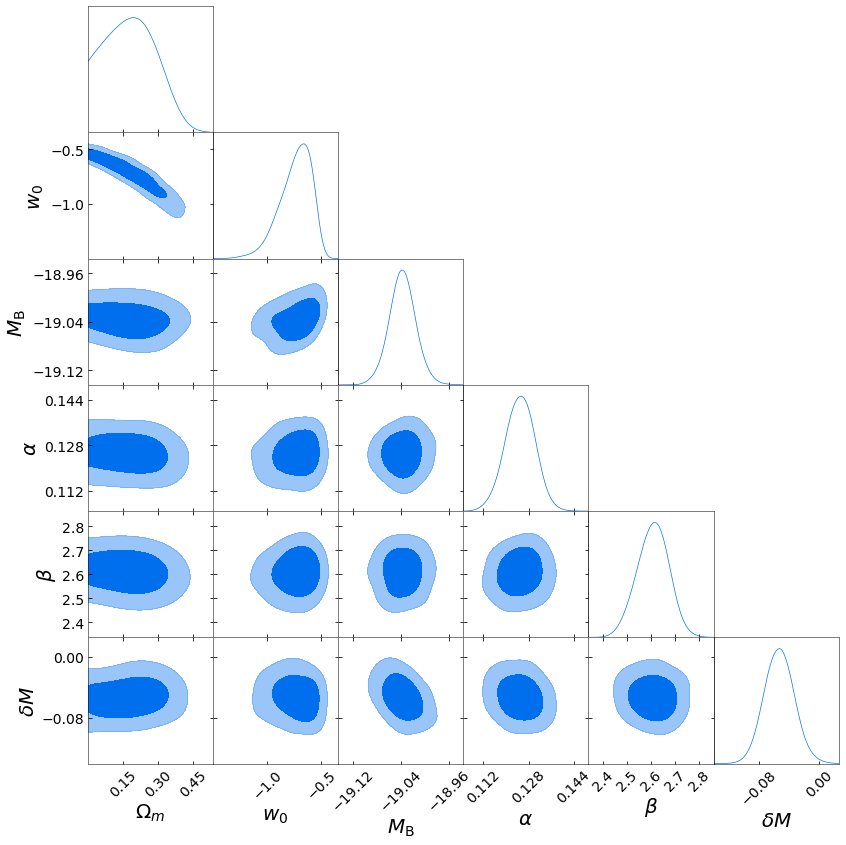

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


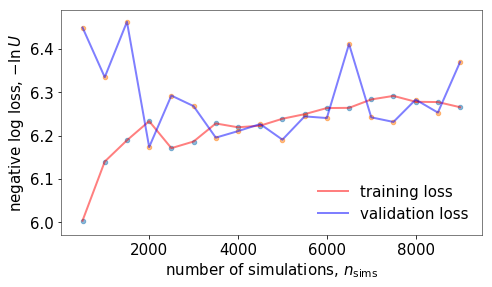

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2961, Val_loss: 6.1971
Epoch 00001, Train_loss: 6.2970, Val_loss: 6.2051
Epoch 00002, Train_loss: 6.2925, Val_loss: 6.2015
Epoch 00003, Train_loss: 6.2940, Val_loss: 6.1998
Epoch 00004, Train_loss: 6.2920, Val_loss: 6.2023
Epoch 00005, Train_loss: 6.2912, Val_loss: 6.2021
Epoch 00006, Train_loss: 6.2918, Val_loss: 6.2023
Epoch 00007, Train_loss: 6.2901, Val_loss: 6.2043
Epoch 00008, Train_loss: 6.2915, Val_loss: 6.2033
Epoch 00009, Train_loss: 6.2892, Val_loss: 6.2047
Epoch 00010, Train_loss: 6.2901, Val_loss: 6.2064
Epoch 00011, Train_loss: 6.2892, Val_loss: 6.2052
Epoch 00012, Train_loss: 6.2891, Val_loss: 6.2058
Epoch 00013, Train_loss: 6.2924, Val_loss: 6.2067
Epoch 00014, Train_loss: 6.2884, Val_loss: 6.2075
Epoch 00015, Train_loss: 6.2887, Val_loss: 6.2095
Epoch 00016, Train_loss: 6.2891, Val_loss: 6.2077
Epoch 00017, Train_loss: 6.2906, Val_loss: 6.2086
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_18.pdf


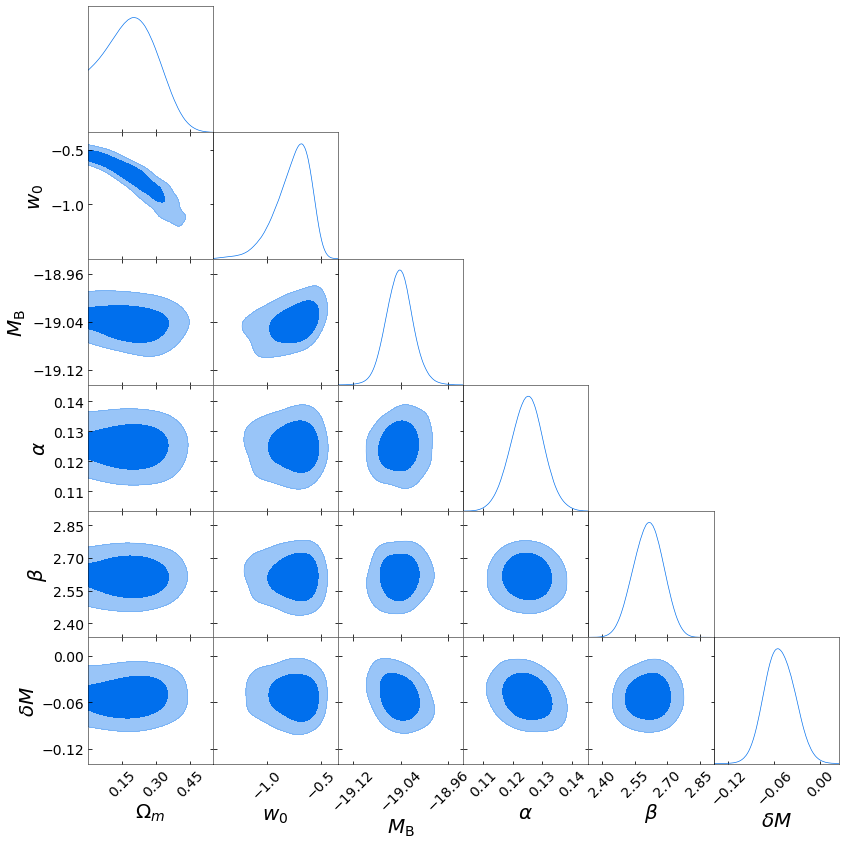

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


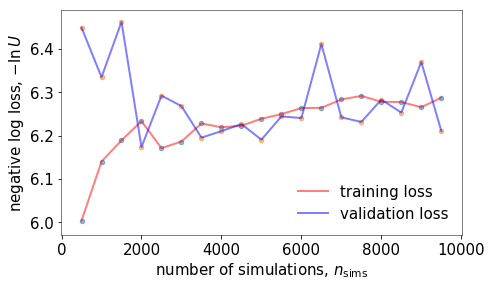

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2905, Val_loss: 6.2551
Epoch 00001, Train_loss: 6.2894, Val_loss: 6.2594
Epoch 00002, Train_loss: 6.2887, Val_loss: 6.2606
Epoch 00003, Train_loss: 6.2907, Val_loss: 6.2582
Epoch 00004, Train_loss: 6.2916, Val_loss: 6.2595
Epoch 00005, Train_loss: 6.2879, Val_loss: 6.2649
Epoch 00006, Train_loss: 6.2885, Val_loss: 6.2669
Epoch 00007, Train_loss: 6.2889, Val_loss: 6.2690
Epoch 00008, Train_loss: 6.2869, Val_loss: 6.2644
Epoch 00009, Train_loss: 6.2906, Val_loss: 6.2628
Epoch 00010, Train_loss: 6.2936, Val_loss: 6.2644
Epoch 00011, Train_loss: 6.2871, Val_loss: 6.2662
Epoch 00012, Train_loss: 6.2858, Val_loss: 6.2650
Epoch 00013, Train_loss: 6.2856, Val_loss: 6.2687
Epoch 00014, Train_loss: 6.2850, Val_loss: 6.2685
Epoch 00015, Train_loss: 6.2860, Val_loss: 6.2703
Epoch 00016, Train_loss: 6.2857, Val_loss: 6.2704
Epoch 00017, Train_loss: 6.2851, Val_loss: 6.2682
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_19.pdf


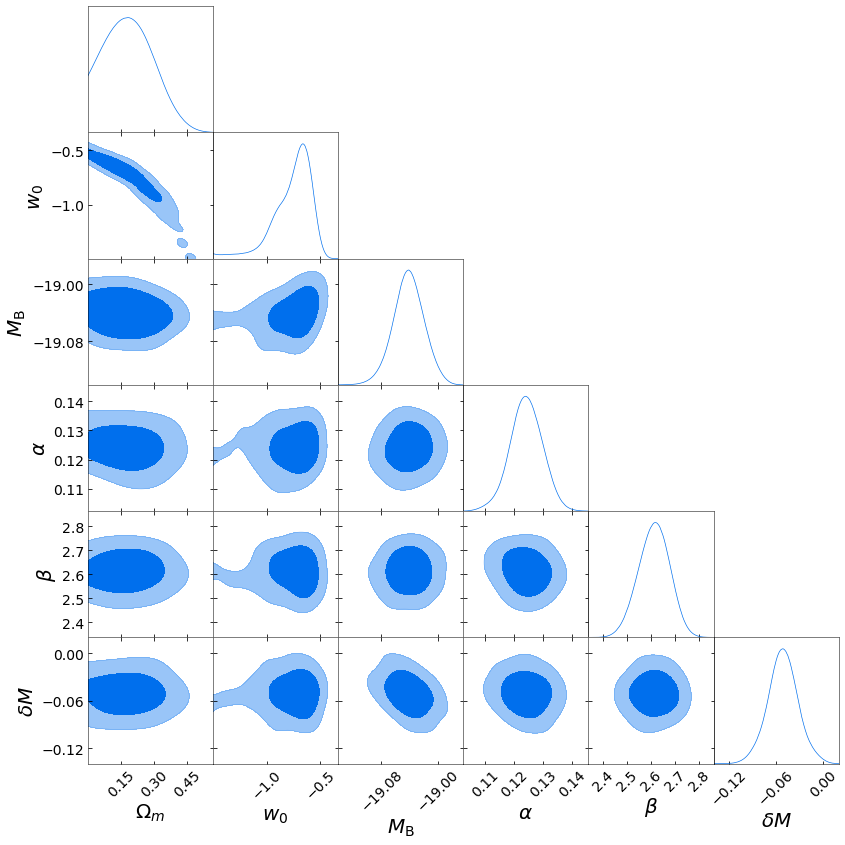

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


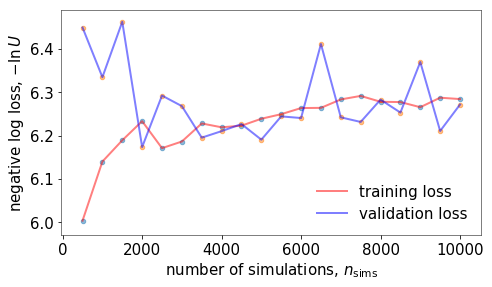

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2919, Val_loss: 6.2875
Epoch 00001, Train_loss: 6.2916, Val_loss: 6.2931
Epoch 00002, Train_loss: 6.2904, Val_loss: 6.2949
Epoch 00003, Train_loss: 6.2901, Val_loss: 6.2924
Epoch 00004, Train_loss: 6.2899, Val_loss: 6.2950
Epoch 00005, Train_loss: 6.2895, Val_loss: 6.2945
Epoch 00006, Train_loss: 6.2892, Val_loss: 6.2993
Epoch 00007, Train_loss: 6.2898, Val_loss: 6.2942
Epoch 00008, Train_loss: 6.2903, Val_loss: 6.2958
Epoch 00009, Train_loss: 6.2890, Val_loss: 6.2953
Epoch 00010, Train_loss: 6.2880, Val_loss: 6.2980
Epoch 00011, Train_loss: 6.2888, Val_loss: 6.2964
Epoch 00012, Train_loss: 6.2889, Val_loss: 6.2960
Epoch 00013, Train_loss: 6.2878, Val_loss: 6.3004
Epoch 00014, Train_loss: 6.2880, Val_loss: 6.2991
Epoch 00015, Train_loss: 6.2886, Val_loss: 6.2994
Epoch 00016, Train_loss: 6.2885, Val_loss: 6.3057
Epoch 00017, Train_loss: 6.2877, Val_loss: 6.3003
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_20.pdf


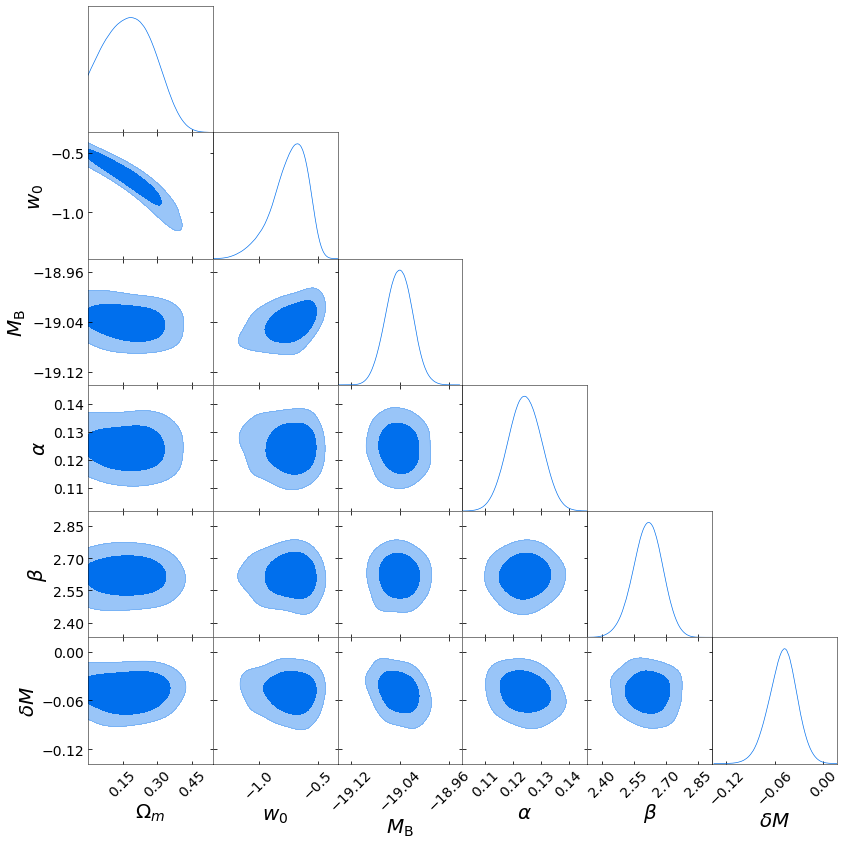

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


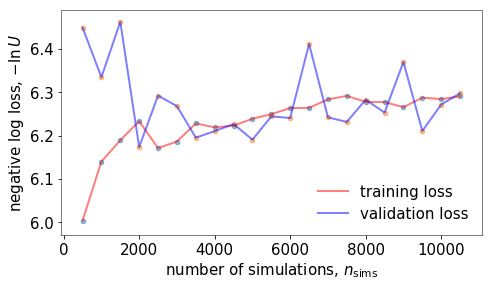

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3002, Val_loss: 6.2231
Epoch 00001, Train_loss: 6.2996, Val_loss: 6.2280
Epoch 00002, Train_loss: 6.2988, Val_loss: 6.2260
Epoch 00003, Train_loss: 6.2983, Val_loss: 6.2265
Epoch 00004, Train_loss: 6.2993, Val_loss: 6.2283
Epoch 00005, Train_loss: 6.2985, Val_loss: 6.2287
Epoch 00006, Train_loss: 6.2980, Val_loss: 6.2300
Epoch 00007, Train_loss: 6.2979, Val_loss: 6.2331
Epoch 00008, Train_loss: 6.2967, Val_loss: 6.2286
Epoch 00009, Train_loss: 6.2963, Val_loss: 6.2291
Epoch 00010, Train_loss: 6.2982, Val_loss: 6.2328
Epoch 00011, Train_loss: 6.2982, Val_loss: 6.2317
Epoch 00012, Train_loss: 6.2963, Val_loss: 6.2292
Epoch 00013, Train_loss: 6.2955, Val_loss: 6.2292
Epoch 00014, Train_loss: 6.2950, Val_loss: 6.2324
Epoch 00015, Train_loss: 6.2951, Val_loss: 6.2296
Epoch 00016, Train_loss: 6.2970, Val_loss: 6.2354
Epoch 00017, Train_loss: 6.2952, Val_loss: 6.2314
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_21.pdf


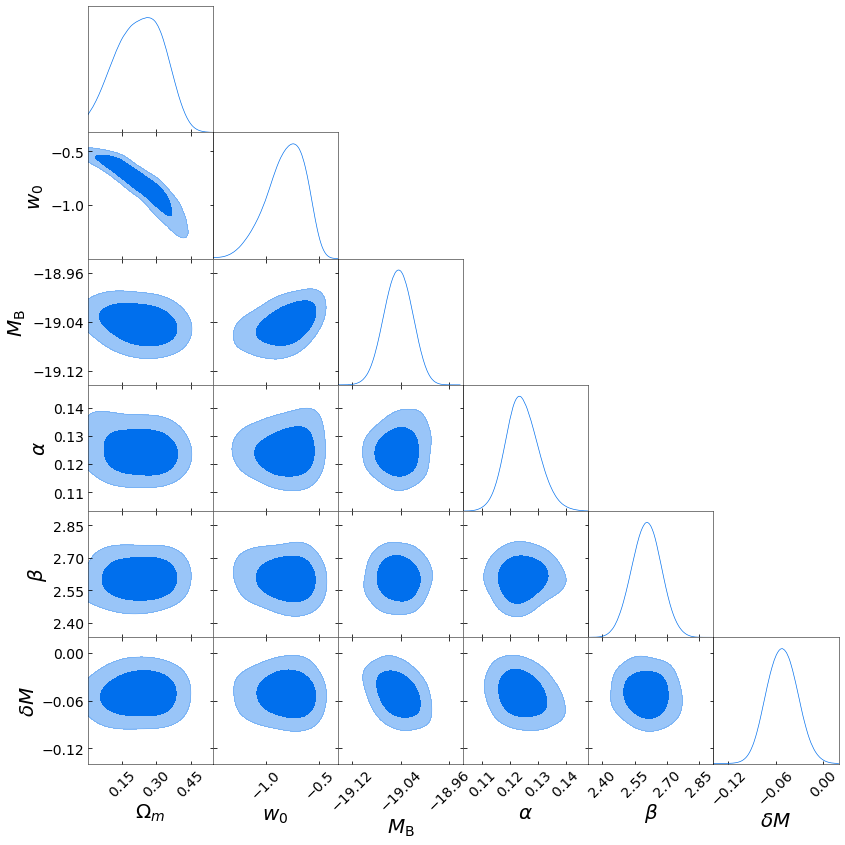

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


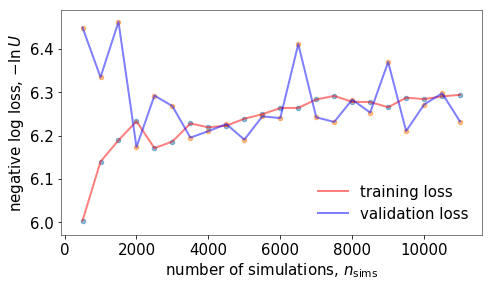

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.2986, Val_loss: 6.3270
Epoch 00001, Train_loss: 6.2970, Val_loss: 6.3272
Epoch 00002, Train_loss: 6.2968, Val_loss: 6.3298
Epoch 00003, Train_loss: 6.2991, Val_loss: 6.3317
Epoch 00004, Train_loss: 6.2957, Val_loss: 6.3310
Epoch 00005, Train_loss: 6.2952, Val_loss: 6.3310
Epoch 00006, Train_loss: 6.2948, Val_loss: 6.3314
Epoch 00007, Train_loss: 6.2960, Val_loss: 6.3323
Epoch 00008, Train_loss: 6.2983, Val_loss: 6.3347
Epoch 00009, Train_loss: 6.2952, Val_loss: 6.3337
Epoch 00010, Train_loss: 6.2936, Val_loss: 6.3336
Epoch 00011, Train_loss: 6.2934, Val_loss: 6.3344
Epoch 00012, Train_loss: 6.2935, Val_loss: 6.3332
Epoch 00013, Train_loss: 6.2927, Val_loss: 6.3314
Epoch 00014, Train_loss: 6.2929, Val_loss: 6.3368
Epoch 00015, Train_loss: 6.2921, Val_loss: 6.3336
Epoch 00016, Train_loss: 6.2929, Val_loss: 6.3336
Epoch 00017, Train_loss: 6.2966, Val_loss: 6.3383
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_22.pdf


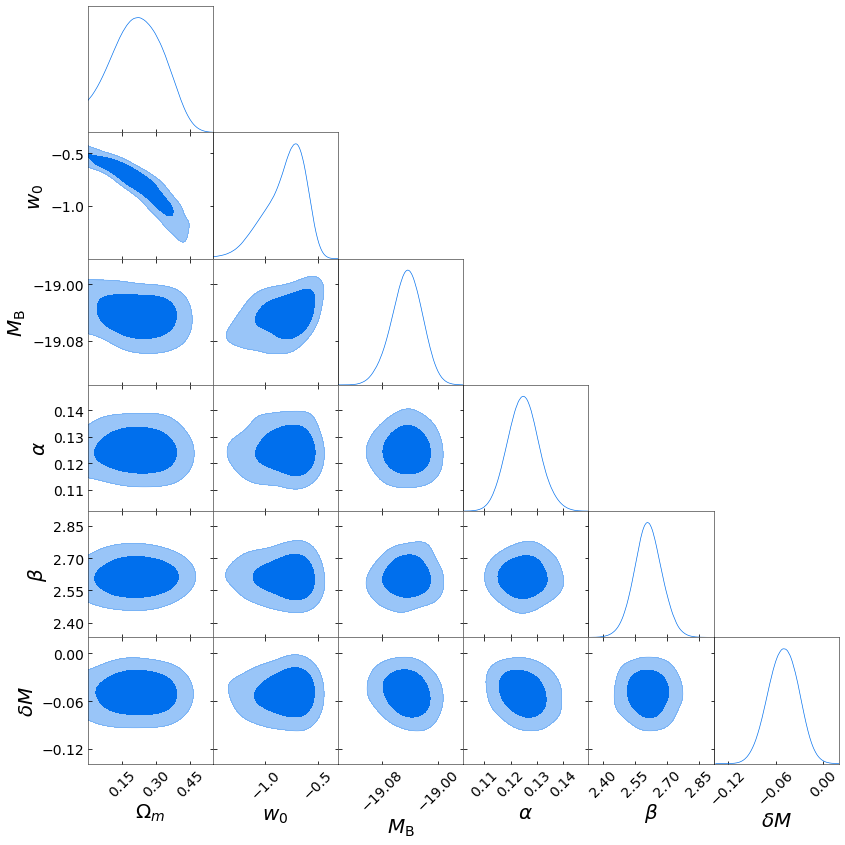

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


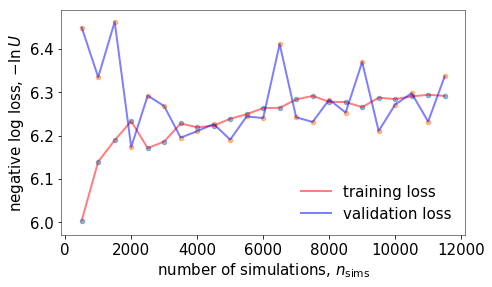

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 6.3002, Val_loss: 6.2808
Epoch 00001, Train_loss: 6.3007, Val_loss: 6.2874
Epoch 00002, Train_loss: 6.3002, Val_loss: 6.2886
Epoch 00003, Train_loss: 6.2993, Val_loss: 6.2873
Epoch 00004, Train_loss: 6.2978, Val_loss: 6.2895
Epoch 00005, Train_loss: 6.3000, Val_loss: 6.2926
Epoch 00006, Train_loss: 6.2980, Val_loss: 6.2905
Epoch 00007, Train_loss: 6.2986, Val_loss: 6.2941
Epoch 00008, Train_loss: 6.2962, Val_loss: 6.2886
Epoch 00009, Train_loss: 6.2969, Val_loss: 6.2900
Epoch 00010, Train_loss: 6.2963, Val_loss: 6.2920
Epoch 00011, Train_loss: 6.2956, Val_loss: 6.2922
Epoch 00012, Train_loss: 6.2958, Val_loss: 6.2914
Epoch 00013, Train_loss: 6.2950, Val_loss: 6.2944
Epoch 00014, Train_loss: 6.2946, Val_loss: 6.2898
Epoch 00015, Train_loss: 6.2944, Val_loss: 6.2926
Epoch 00016, Train_loss: 6.2948, Val_loss: 6.2922
Epoch 00017, Train_loss: 6.2943, Val_loss: 6.2927
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/jla_supernovae/results/mdntmp_model


Sampling approximate posterior...
Done.
Saving simulators/jla_supernovae/results/mdnseq_train_post_23.pdf


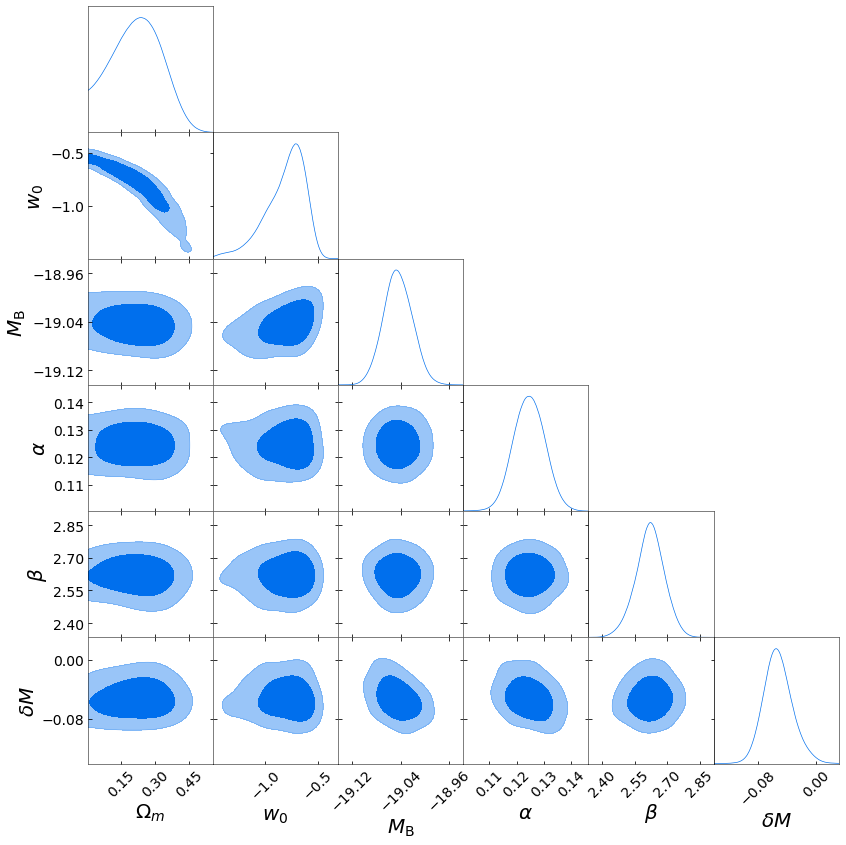

Saving simulators/jla_supernovae/results/mdnseq_train_loss.pdf


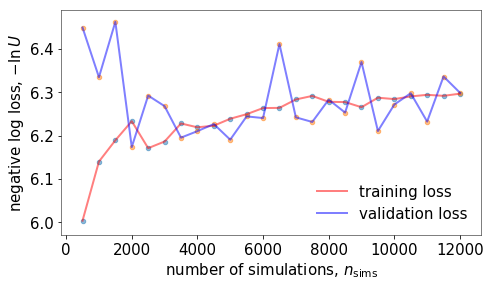

In [17]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)